<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #7: Ranking

<span style="color:blue; font-size: 12pt">Anastasia Zukhba </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Organization Info</h1> 

**Дополнительный материал для выполнения дз**:

[1] C.J.C. Burges, T. Shaked, E. Renshaw, A. Lazier, M. Deeds, N. Hamilton and G. Hullender. Learning to rank using gradient descent. In Proc. of ICML, pages 89-96, 2005.

[2] Y. Freund, R. Iyer, R. Schapire, and Y. Singer. An efficient boosting algorithm for combining preferences. The Journal of Machine Learning Research, 4: 933-969, 2003.

[3] J. Xu and H. Li. AdaRank: a boosting algorithm for information retrieval. In Proc. of SIGIR, pages 391-398, 2007.

[4] D. Metzler and W.B. Croft. Linear feature-based models for information retrieval. Information Retrieval, 10(3): 257-274, 2007.

[5] Q. Wu, C.J.C. Burges, K. Svore and J. Gao. Adapting Boosting for Information Retrieval Measures. Journal of Information Retrieval, 2007.

[6] J.H. Friedman. Greedy function approximation: A gradient boosting machine. Technical Report, IMS Reitz Lecture, Stanford, 1999; see also Annals of Statistics, 2001.

[7] Z. Cao, T. Qin, T.Y. Liu, M. Tsai and H. Li. Learning to Rank: From Pairwise Approach to Listwise Approach. ICML 2007. 

[8] L. Breiman. Random Forests. Machine Learning 45 (1): 5–32, 2001.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было.

<h1 align="center">Check Questions (10%)</h1> 

**1.** Что является объектом в задаче обучения ранжированию? Какой смысл имеют целевые метки? Какие объекты сравнимы между собой?

<Ответ>

**2.** В чём преимущество метрики NDCG перед метрикой MAP?

<Ответ>

**3.** Почему говорят, что все основные метрики качества дискретны?

<Ответ>

**4.** В чем преимущество факторизации в модели RankNet?

<Ответ>

**5.** Как решается проблема дискретности метрик в моделях LambdaRank и LambdaMART?

<Ответ>

**6.** Какое преобразование данных используется в модели RankSVM?

<Ответ>

**7.** Как изменится верхняя оценка на скорость сходимости в модели PageRank, если считать, что при операции телепортации пользователь всегда выбирает страницу, отличную от текущей?

<Ответ>

**8.** Имеет ли смысл выполнять итерации в методе power iteration для разных начальных распределений $\Pi^{(0)}$ с точки зрения теории? А с точки зрения практического применения, не обязательно при этом доводя до сходимости?

<Ответ>

<h1 align="center"> Theoretical tasks (10%)</h1>

**1.** Предположим, что известные вероятностности в модели RankNet задаются по правилу
$$Q_{ij} = \mathsf{Q}(X_i \triangleright X_j) = \frac{1}{1 + e^{-\sigma (Y_i - Y_j)}}.$$
Можно ли провести факторизацию в данной модели?

<Решение>

**2.** Покажите, что вес PageRank каждой страницы не меньше $\frac{p}{|V|}$.

<Решение>

**3.** Пользователь браузера в дополнение к кликам по ссылкам один раз может перейти по кнопке *Назад* и вернуться на предыдущую страницу. Можно ли такую модель описать с помощью однородной марковской цепи? Если да, опишите, если нет, докажите.

<Решение>

<h1 align="center"> Practical tasks (80%)</h1>
# Part 1 (15%)

In [6]:
import numpy as np
from scipy.stats import bernoulli
import networkx
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.parse import urlparse, urlunparse
from time import sleep
from itertools import product
import matplotlib.pyplot as plt

%matplotlib inline
# plt.rc('text', usetex=True)
# plt.rc('text.latex', unicode=True)
# plt.rc('text.latex', preamble='\\usepackage[utf8]{inputenc}')
# plt.rc('text.latex', preamble='\\usepackage[russian]{babel}')
# plt.rc('font', family='serif', size='16')
# это не работает

## Вычисление весов PageRank power-методом.

Реализовать удобнее с помощью функции np.nan_to_num, которая в данном numpy.array заменит все вхождения nan на ноль. Это позволяет удобно производить поэлементное деление одного вектора на другой в случае, если во втором векторе есть нули.

**Внимание!** Эти функции будут проверяться автоматическими тестами.

In [7]:
def create_page_rank_markov_chain(links, damping_factor=0.15, N=None):
    ''' По веб-графу со списком ребер links строит матрицу 
    переходных вероятностей соответствующей марковской цепи.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        damping_factor --- вероятность перехода не по ссылке (float);
        N --- число веб-страниц;
        
        Возвращает prob_matrix --- numpy.matrix, shape=(|V|, |V|).
    '''

    links = np.array(links)
    if N is None:
        N = links.max() + 1
        
    matrix = np.zeros(shape=(N, N))
    
    for l in links:
        matrix[l[1], l[0]] = 1
        
    damping_factor_vec = ((matrix.sum(axis=0) == 0) * (1 - damping_factor) + damping_factor) * (matrix.sum(axis=0) != N)
    
    with np.errstate(divide='ignore', invalid='ignore'):
        prob_matrix = np.nan_to_num(matrix / matrix.sum(axis=0)) * (1 - damping_factor_vec) + \
                      np.nan_to_num((1 - matrix) / (1 - matrix).sum(axis=0)) * damping_factor_vec
    
    return np.array(prob_matrix.T)



In [8]:

def page_rank(links, start_distribution, damping_factor=0.15, 
              tolerance=10 ** (-7), N=None, return_trace=False):
    ''' Вычисляет веса PageRank для веб-графа со списком ребер links 
    степенным методом, начиная с начального распределения start_distribution, 
    доводя до сходимости с точностью tolerance.
    
        links --- список (list) пар вершин (tuple), 
                может быть передан в виде numpy.array, shape=(|E|, 2);
        start_distribution --- вектор размерности |V| в формате numpy.array;
        damping_factor --- вероятность перехода не по ссылке (float);
        tolerance --- точность вычисления предельного распределения;
        return_trace --- если указана, то возвращает список распределений во 
                            все моменты времени до сходимости
    
        Возвращает:
        1). если return_trace == False, то возвращает distribution --- 
        приближение предельного распределения цепи,
        которое соответствует весам PageRank.
        Имеет тип numpy.array размерности |V|.
        2). если return_trace == True, то возвращает также trace ---
        список распределений во все моменты времени до сходимости. 
        Имеет тип numpy.array размерности 
        (количество итераций) на |V|.
    '''
    
    
    links = np.array(links)
    if N is None:
        N = links.max() + 1 
    
    prob_matrix = create_page_rank_markov_chain(links, damping_factor=damping_factor, N=N)
    distribution = np.matrix(start_distribution)
    previous_distribution = -np.ones_like(distribution)
    trace = [distribution.ravel()]
    
    while(np.linalg.norm(previous_distribution - distribution) > tolerance):      
        previous_distribution = distribution
        distribution = previous_distribution * prob_matrix
        trace.append(distribution.ravel())
    
    if return_trace:
        return np.array(distribution).ravel(), np.array(trace)
    else:
        return np.array(distribution).ravel()

# Проверка реализации
Напишите для начала функцию для генерации случайного ориентированного графа $G(n, p)$. Случайный граф генерируется следующий образом. Берется множество $\{0, ..., n-1\}$, которое есть множество вершин этого графа. Ребро $(i, j)$ (пара упорядочена, возможно повторение) добавляется в граф независимо от других ребер с вероятностью $p$.

In [9]:
def random_graph(n, p):
    return [(i, j) for i in range(n) for j in range(n) if np.random.rand() < p]

In [143]:
g = random_graph(3, 0.5)
g

[(0, 0), (0, 1), (1, 0), (1, 2)]

In [144]:
create_page_rank_markov_chain(g, 0.1)

array([[ 0.45      ,  0.45      ,  0.1       ],
       [ 0.45      ,  0.1       ,  0.45      ],
       [ 0.33333333,  0.33333333,  0.33333333]])

Теперь сгенерируем случайный граф и нарисуем его.

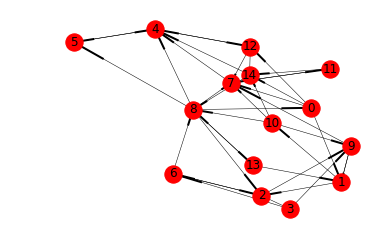

In [145]:
N, p = 15, 0.2
edges = random_graph(N, p)
prob = create_page_rank_markov_chain(edges)
#print(prob)
#print(prob.sum(axis=1))

G = networkx.DiGraph()
G.add_nodes_from(range(N))
G.add_edges_from(edges)
plt.axis('off')
networkx.draw_networkx(G, width=0.5)

In [146]:
help(networkx.DiGraph)

Help on class DiGraph in module networkx.classes.digraph:

class DiGraph(networkx.classes.graph.Graph)
 |  Base class for directed graphs.
 |  
 |  A DiGraph stores nodes and edges with optional data, or attributes.
 |  
 |  DiGraphs hold directed edges.  Self loops are allowed but multiple
 |  (parallel) edges are not.
 |  
 |  Nodes can be arbitrary (hashable) Python objects with optional
 |  key/value attributes. By convention `None` is not used as a node.
 |  
 |  Edges are represented as links between nodes with optional
 |  key/value attributes.
 |  
 |  Parameters
 |  ----------
 |  data : input graph
 |      Data to initialize graph. If data=None (default) an empty
 |      graph is created.  The data can be any format that is supported
 |      by the to_networkx_graph() function, currently including edge list,
 |      dict of dicts, dict of lists, NetworkX graph, NumPy matrix
 |      or 2d ndarray, SciPy sparse matrix, or PyGraphviz graph.
 |  
 |  attr : keyword arguments, opt

Посчитаем его PageRank и изобразим так, чтобы размер вершины был пропорционален ее весу.

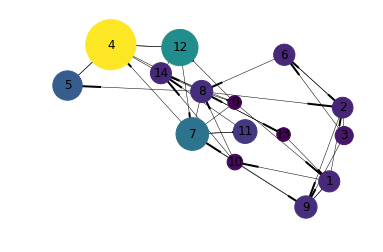

In [147]:
start_distribution = np.ones((1, N)) / N
#print((prob.T * (prob.T * np.matrix(start_distribution).T)))
pr_distribution, trace = page_rank(edges, start_distribution, return_trace=True)
#print(pr_distribution.sum())
#print(trace)

size_const = 10 ** 4
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Как мы уже отмечали выше, эргодическая теорема дает верхнюю оценку на скорость сходимости. Давайте посмотрим, насколько она является точной. Для этого при вычислении PageRank нужно установить флаг return_trace.

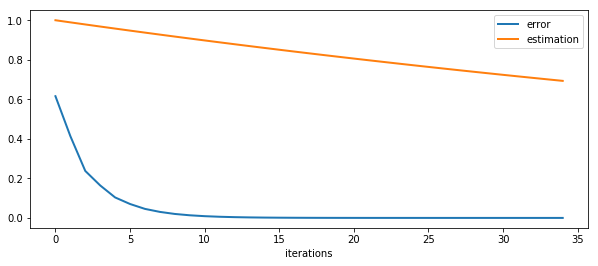

In [148]:
prob = create_page_rank_markov_chain(edges)
pr_distribution, pr_trace = page_rank(edges, start_distribution, 
                                      return_trace=True)
errors = np.abs(pr_trace - pr_trace[-1]).sum(axis=(1, 2))

plt.figure(figsize=(10, 4))
x = np.arange(len(errors))
plt.plot(x, errors, lw=2, label='error')
plt.plot(x, (1 - prob.min()) ** x, 
         lw=2, label='estimation')
plt.legend()
plt.xlabel('iterations')
plt.show()

Эргодическая теорема не дает точную оценку скорости сходимости, реальная скорость сходимости значительно больше

Проведите небольшое исследование. В ходе исследования выясните, как скорость сходимости (количество итераций до сходимости) зависит от $n$ и $p$, а так же начального распределения. Вычислите также веса PageRank для некоторых неслучайных графов. В каждом случае стройте графики. От чего зависит вес вершины?

In [149]:
def experiment(n, p, distr, r=5):
    if r != 1:
        return np.array([experiment(n, p, distr, 1) for i in range(r)]).mean()
    edges = random_graph(n, p)
    start_distr = np.ones((1, n)) / n if distr == "uniform" else np.eye(n)[0]
    pr_distribution, trace = page_rank(edges, start_distr, N=n, return_trace=True)
    return len(trace) 
    
    
result_uni = np.array([[experiment(n, p, "uniform") for n in [10, 100, 1000]] for p in [0.1, 0.5, 0.9, 1.0]])

result_1 = np.array([[experiment(n, p, "all_in_1") for n in [10, 100, 1000]] for p in [0.1, 0.5, 0.9, 1.0]])
    

In [151]:
np.array(result_uni)

array([[ 43.6,  12.2,   6.8],
       [ 13.6,   7. ,   5. ],
       [  6. ,   5. ,   4. ],
       [  2. ,   2. ,   2. ]])

In [154]:
np.array(result_1)

array([[ 32.2,  14.6,   9. ],
       [ 12.6,   8.8,   7. ],
       [  7.4,   6.8,   5.8],
       [  3. ,   3. ,   3. ]])

Вывод: скорость сходимости растет с увеличением n и с увеличением p. Так же она выше в случае, если начальное распределение равномерное (по сравнению с вырожденным распределением, где вероятность одного значения равна 1)

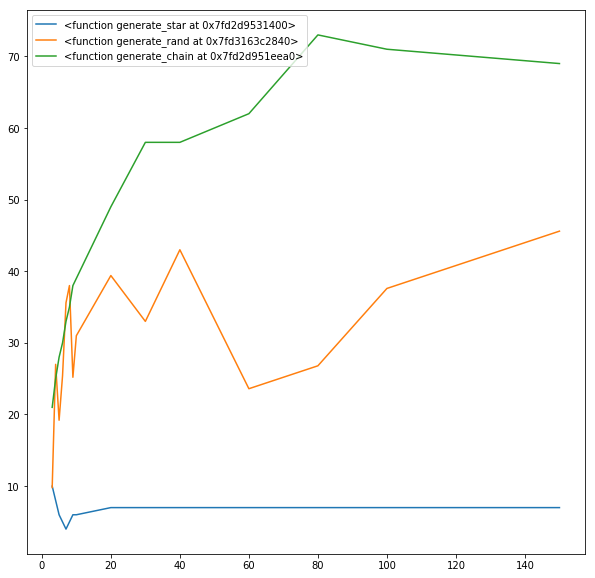

In [162]:
def generate_star(n):
    return [(0, i) for i in range(1, n)]

def generate_chain(n):
    return [(i, i + 1) for i in range(n - 1)]

def generate_rand(n):
    return random_graph(n, 2 / n)

def experiment(n, gen, r=5):
    if r != 1:
        return np.array([experiment(n, gen, 1) for i in range(r)]).mean()
    edges = gen(n)
    start_distr = np.ones((1, n)) / n
    pr_distribution, trace = page_rank(edges, start_distr, N=n, return_trace=True)
    return len(trace)

plt.figure(figsize=(10, 10))
xs = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 60, 80, 100, 150]
for gen in [generate_star, generate_rand, generate_chain]:
    plt.plot(xs, [experiment(n, gen) for n in xs], label=str(gen))
plt.legend()
plt.show()

Исследование проведено для графов-звезд, графов-цепей и случайных графов. Видим, что без особой зависимости от числа вершин, page_rank для графа-звезды сходится быстрее всего, а графа-цепи медленнее всего. Случайный граф занимает промежуточную позицию

In [165]:
start_distr = np.ones((1, N)) / N
print("star-graph ranks:", page_rank(generate_star(N), start_distr))
print("chain-graph ranks:", page_rank(generate_chain(N), start_distr))
print("rand-graph ranks:", page_rank(generate_rand(N), start_distr))

star-graph ranks: [ 0.07272727  0.06623377  0.06623377  0.06623377  0.06623377  0.06623377
  0.06623377  0.06623377  0.06623377  0.06623377  0.06623377  0.06623377
  0.06623377  0.06623377  0.06623377]
chain-graph ranks: [ 0.01582625  0.02910899  0.04025701  0.04961339  0.05746607  0.06405671
  0.06958815  0.0742306   0.07812695  0.08139709  0.08414166  0.08644513
  0.08837839  0.09000093  0.09136268]
rand-graph ranks: [ 0.02879529  0.08739902  0.04769943  0.10899642  0.07146764  0.0231628
  0.03670965  0.10672897  0.05792079  0.04970792  0.1097444   0.12421786
  0.02980814  0.02879529  0.08884638]


Здесь результаты говорят сами за себя. В случае случайного графа ранки случайные, но около 1/n. В случае цепи они растут в сторону, куда идет цепь. В случае звезды ранк центральной вершины чуть больше, чем у остальных. С одной стороны это странно (почему не 0?). Но, если присмотреться, видим, что вероятности перехода там почти одинаковые для любой пары вершин. При этом центральную вершину "вытягивает" вероятность пойти не по ссылке (она больше 1 / (n - 1)), то есть в саму себя. А из всех остальных вершин переходы чисто случайные.

# Part 2 (15%)

В этой части вам предстоит построить реальный веб-граф и посчитать его PageRank. Ниже определены вспомогательные функции.

In [10]:
def load_links(url, sleep_time=1, attempts=5, timeout=20):
    ''' Загружает страницу по ссылке url и выдает список ссылок, 
    на которые ссылается данная страница.
        url --- string, адрес страницы в интернете;
        sleep_time --- задержка перед загрузкой страницы;
        timeout --- время ожидания загрузки страницы;
        attempts --- число попыток загрузки страницы. 
        Попытка считается неудачной, если выбрасывается исключение.
    
        В случае, если за attempts попыток не удалось загрузить страницу,
        то последнее исключение пробрасывается дальше.
    '''
    
    sleep(sleep_time)
    parsed_url = urlparse(url)
    links = []

    # Попытки загрузить страницу
    for i in range(attempts):
        try:
            # Ловить исключения только из urlopen может быть недостаточно. 
            # Он может выдавать какой-то бред вместо исключения, 
            # из-за которого исключение сгенерирует BeautifulSoup
            soup = BeautifulSoup(urlopen(url, timeout=timeout), 'lxml')
            break
            
        except Exception as e:
            print(e)
            if i == attempts - 1:
                raise e

    for tag_a in soup('a'):  # Посмотр всех ссылочных тегов
        if 'href' in tag_a.attrs:
            link = list(urlparse(tag_a['href']))
            
            # Если ссылка является относительной,
            # то ее нужно перевести в абсолютную
            if link[0] == '': link[0] = parsed_url.scheme
            if link[1] == '': link[1] = parsed_url.netloc
            
            links.append(urlunparse(link))
            
    return links


def get_site(url):
    ''' По ссылке url возвращает адрес сайта. '''
    
    return urlparse(url).netloc

Код ниже загружает $N$ веб-страниц, начиная с некоторой стартовой страницы и переходя по ссылкам. Загрузка происходит методом обхода в ширину. Все собранные урлы страниц хранятся в urls. В links хранится список ссылок с одной страницы на другую. Особенность кода такова, что в urls хранятся все встреченные урлы, которых может быть сильно больше $N$. Аналогично, в links ребра могут ссылаться на страницы с номером больше $N$. Однако, все ребра из links начинаются только в первых $N$ страницах. Таким образом, для построения веб-графа нужно удалить все, что связано с вершинами, которые не входят в первые $N$.

Это очень примерный шаблон, к тому же не оптимальный. Можете вообще его не использовать и написать свое.

In [11]:
urls = ['http://www.maria-ra.ru/']
site = get_site(urls[0])
links = []
from tqdm import tqdm
N = 1000
for i in tqdm(range(N)):
    try:
        # Загружаем страницу по урлу и извлекаем из него все ссылки
        # Не выставляйте sleep_time слишком маленьким, 
        # а то еще забанят где-нибудь
        links_from_url = load_links(urls[i], sleep_time=0.5)
        # Если мы хотим переходить по ссылкам только определенного сайта
        links_from_url = list(filter(lambda x: get_site(x) == site, 
                                     links_from_url))
        
        # Добавляем соответствующие вершины и ребра в веб-граф
        for j in range(len(links_from_url)):
            link = links_from_url[j]
            for c in ['?', '&', '@']:
                if link.find(c) != -1:
                    link = link[:link.find(c)]
            if link.endswith('.jpg'):
                continue
            if link.endswith('.pdf'):
                continue
            
            # Такая ссылка уже есть
            if links_from_url[j] in urls:
                links.append((i, urls.index(link)))
            
            # Новая ссылка
            else:
                if link.find("maria-ra") == -1:
                    continue
                print(link)
                links.append((i, len(urls)))
                urls.append(link)
                
    except:
        pass  # Не загрузилась с 5 попытки, ну и ладно

  0%|          | 1/1000 [00:01<19:56,  1.20s/it]

http://www.maria-ra.ru/novosti/vyigray-poezdku-v-sheregesh/
http://www.maria-ra.ru/aktsii
http://www.maria-ra.ru/o-nas/karta-seti/
http://www.maria-ra.ru/o-nas/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/karera-v-seti/benefits/
http://www.maria-ra.ru/partneram/
http://www.maria-ra.ru/novosti/s-mariya-ra-ot-zdorovogo-pitaniya-do-zdorovogo-obraza-zhizni-bolee-12-000-barnaultsev-prinyalo-uchas/
http://www.maria-ra.ru/retsepty/
http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/novosti/otkrytie-novogo-magazina-949-1/
http://www.maria-ra.ru/aktsii/
http://www.maria-ra.ru/novosti/otkrytie-novogo-magazina-948/
http://www.maria-ra.ru
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/anketa-rezyume/
http://www.maria-ra.ru

  0%|          | 3/1000 [00:03<17:46,  1.07s/it]

http://www.maria-ra.ru/aktsii/poems/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli/


  0%|          | 4/1000 [00:04<17:08,  1.03s/it]

http://www.maria-ra.ru/o-nas/products-under-its-own-trade-mark
http://www.maria-ra.ru/o-nas/kontakty/


  0%|          | 5/1000 [00:05<16:35,  1.00s/it]

http://www.maria-ra.ru/o-nas/karta-seti/index.php


  1%|          | 6/1000 [00:05<16:21,  1.01it/s]

http://www.maria-ra.ru/aktsii/image/pervyy-belokurikhinskiy-lyzhnyy-marafon-sostoyalsya/
http://www.maria-ra.ru/aktsii/image/khochesh-byt-schastlivym-bud-zdorovym/
http://www.maria-ra.ru/aktsii/image/kompaniya-mariya-ra-priglashaet-na-otkrytie-trassy-zdorovya/
http://www.maria-ra.ru/aktsii/image/v-tts-raduga-g-rubtsovska-tts-raduga-g-kemerovo-tts-rivera-g-biysk-tts-tsum-g-osinniki-zapushchena-a/
http://www.maria-ra.ru/aktsii/image/priglashaem-vsekh-na-subbotnie-novogodnie-elki-12-19-26-dekabrya-v-tts-rayon-g-mezhdurechensk-i-tts-/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


  1%|          | 7/1000 [00:08<19:45,  1.19s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/otkrytie-novogo-magazina-943/
http://www.maria-ra.ru/novosti/kompaniya-mariya-ra-provela-aktsiyu-v-novosibirske-delaem-mir-luchshe-/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  1%|          | 8/1000 [00:09<19:05,  1.15s/it]

http://www.maria-ra.ru/upload/Регламент предоставления доступа в КСЭД ООО Розница К-1 сотрудникам организации.docx


  1%|          | 9/1000 [00:10<18:33,  1.12s/it]

http://www.maria-ra.ru/partneram/proizvodstvo/
http://www.maria-ra.ru/partneram/logistics/
http://www.maria-ra.ru/partneram/partneram/
http://www.maria-ra.ru/bitrix/components/news/iblock.element.add.form/templates/КОММЕРЧЕСКОЕ ПРЕДЛОЖЕНИЕ для поставщиков-2015.xls
http://www.maria-ra.ru/partneram/automatic-system-of-transfer-of-the-commercial-proposals/index.php


  1%|          | 10/1000 [00:10<18:06,  1.10s/it]

http://www.maria-ra.ru/ https://yadi.sk/d/bDuA2s7X3NPTKq
http://www.maria-ra.ru/upload/iblock/1e4/BRS_9226.JPG
http://www.maria-ra.ru/upload/iblock/81a/BRS_9338.JPG
http://www.maria-ra.ru/upload/iblock/b67/BRS_9372.JPG
http://www.maria-ra.ru/upload/iblock/4c8/BRS_9558.JPG
http://www.maria-ra.ru/upload/iblock/1eb/BRS_9576.JPG
http://www.maria-ra.ru/upload/iblock/f3a/BRS_9609.JPG
http://www.maria-ra.ru/upload/iblock/0d6/BRS_9650.JPG
http://www.maria-ra.ru/upload/iblock/b69/BRS_9995.JPG
http://www.maria-ra.ru/upload/iblock/921/BRS_9037.JPG
http://www.maria-ra.ru/upload/iblock/553/BRS_9494.JPG


  1%|          | 11/1000 [00:11<17:44,  1.08s/it]

http://www.maria-ra.ru/retsepty/buterbrody/
http://www.maria-ra.ru/retsepty/garniry/
http://www.maria-ra.ru/retsepty/zakuski/
http://www.maria-ra.ru/retsepty/konditerskie-izdeliya/
http://www.maria-ra.ru/retsepty/muchnye-blyuda/
http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/sousy/
http://www.maria-ra.ru/retsepty/supy/


  1%|          | 12/1000 [00:12<17:28,  1.06s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


  2%|▏         | 17/1000 [00:17<16:32,  1.01s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/otchet-o-blagotvoritelnoy-deyatelnosti-kompanii-mariya-ra/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/regionalnyy-turnir-sovmestno-s-sk-yubileynyy-i-kompaniey-mariya-ra-g-rubtsovsk/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/kompaniya-mariya-ra-okazala-sponsorskuyu-pomoshch-k-9-maya/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/blagotvoritelnaya-aktsiya-mariya-ra-i-nestle-prazdnik-sostoyalsya2508/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/kompaniya-mariya-ra-pozdravila-bolee-10-000-svoikh-samykh-malenkikh-pokupateley-s-dnem-zashchity-det/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


  2%|▏         | 18/1000 [00:18<16:25,  1.00s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/podvedeny-itogi-aktsii-dobryy-doktor2/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/barnaultsy-i-gosti-goroda-zakryli-zimniy-sezon-2013-2014-gg-na-trasse-zdorovya/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/my-zabotimsya-o-vashem-zdorove-/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/pervye-bolshie-studencheskie-gonki-na-prizy-mariya-ra-sostoyalis/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/bolshie-studencheskie-gonki-na-prizy-mariya-ra-/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


  2%|▏         | 19/1000 [00:18<16:17,  1.00it/s]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/poltory-tysyachi-chelovek-posetili-den-khodby-na-barnaulskoy-trasse-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/kompaniya-mariya-ra-zakryla-ocherednoy-lyzhnyy-sezon-na-trasse-zdorovya-v-tomske/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/kompaniya-mariya-ra-zakryla-ocherednoy-lyzhnyy-sezon-na-trasse-zdorovya-v-barnaule/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-dvenadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-14-03-2016/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/zakrytie-zimnego-sezona-na-trasse-zdorovya-mariya-ra-v-s-altayskom-sostoyalos/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


  2%|▏         | 20/1000 [00:20<16:24,  1.00s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


  2%|▏         | 21/1000 [00:21<16:30,  1.01s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


  2%|▎         | 25/1000 [00:25<16:34,  1.02s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

  3%|▎         | 26/1000 [00:26<16:28,  1.01s/it]

http://www.maria-ra.ru/upload/iblock/64c/Договор поставки.zip
http://www.maria-ra.ru/upload/iblock/a64/КОММЕРЧЕСКОЕ ПРЕДЛОЖЕНИЕ для поставщиков-2015.zip
http://www.maria-ra.ru/upload/iblock/d79/Документы.zip
http://www.maria-ra.ru/upload/iblock/fb5/Регламент взаимодействия участников КСЭД сайт.docx


  3%|▎         | 27/1000 [00:27<16:22,  1.01s/it]

http://www.maria-ra.ru/upload/News/КОММЕРЧЕСКОЕ ПРЕДЛОЖЕНИЕ для поставщиков-2016.xls
http://www.maria-ra.ru/upload/Анкета-заявка для логистических компаний.xls
mailto://www.maria-ra.ru/km18


  3%|▎         | 28/1000 [00:28<16:16,  1.00s/it]

http://www.maria-ra.ru/aktsii/poems/stikhotvoreniya-o-lyzhne-i-zime/
http://www.maria-ra.ru/aktsii/poems/avtor-stikhov-babich-anatoliy-sergeevich/


  3%|▎         | 29/1000 [00:28<16:10,  1.00it/s]

http://www.maria-ra.ru/aktsii/pobediteli2017/pobediteli-glavnykh-prizov-ot-kompanii-mariya-ra-po-aktsii-za-kvartiroy-na-lyzhakh-/
http://www.maria-ra.ru/aktsii/pobediteli2017/schastlivye-pobediteli-pyatnadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-13-03-2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/schastlivye-pobediteli-chetyrnadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-06-03-2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/schastlivye-pobediteli-trinadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-27-02-2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/schastlivye-pobediteli-dvenadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-20-02-2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/


  3%|▎         | 30/1000 [00:29<16:09,  1.00it/s]

http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-dvenadtsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-14-03-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-odinnatsatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-29-02-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-desyatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-29-02-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-devyatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-15-02-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-vosmogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-15-02-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/


  3%|▎         | 31/1000 [00:30<16:03,  1.01it/s]

http://www.maria-ra.ru/aktsii/pobediteli/pobediteli-rozygrysha-15-ot-24-03-2015/
http://www.maria-ra.ru/aktsii/pobediteli/pobediteli-rozygrysha-14-ot-17-03-2015/
http://www.maria-ra.ru/aktsii/pobediteli/pobediteli-rozygrysha-13-ot-10-03-2015/
http://www.maria-ra.ru/aktsii/pobediteli/pobediteli-rozygrysha-11-ot-3-03-2015/
http://www.maria-ra.ru/aktsii/pobediteli/pobediteli-rozygrysha-11-ot-24-02-2015/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/


  3%|▎         | 33/1000 [00:32<16:01,  1.01it/s]

mailto://www.maria-ra.ru/ura
mailto://www.maria-ra.ru/partner
mailto://www.maria-ra.ru/p125
mailto://www.maria-ra.ru/p145
mailto://www.maria-ra.ru/p36
mailto://www.maria-ra.ru/e7
mailto://www.maria-ra.ru/it110
mailto://www.maria-ra.ru/rm9
mailto://www.maria-ra.ru/kl76
mailto://www.maria-ra.ru/kl76


  4%|▎         | 35/1000 [00:34<15:53,  1.01it/s]

http://www.maria-ra.ru/upload/iblock/1cd/IMG_1231.JPG
http://www.maria-ra.ru/upload/iblock/06f/IMG_1272.JPG
http://www.maria-ra.ru/upload/iblock/7de/IMG_1352.JPG
http://www.maria-ra.ru/upload/iblock/978/IMG_1430.JPG
http://www.maria-ra.ru/upload/iblock/894/IMG_1604 - копия.JPG
http://www.maria-ra.ru/upload/iblock/682/IMG_7187.JPG
http://www.maria-ra.ru/upload/iblock/44b/IMG_7209.JPG
http://www.maria-ra.ru/upload/iblock/87b/IMG_7294.JPG
http://www.maria-ra.ru/upload/iblock/790/IMG_7304.JPG


  4%|▍         | 40/1000 [00:39<15:58,  1.00it/s]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


  4%|▍         | 41/1000 [00:41<16:03,  1.00s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


  4%|▍         | 42/1000 [00:42<16:07,  1.01s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


  4%|▍         | 43/1000 [00:43<16:03,  1.01s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


  4%|▍         | 44/1000 [00:44<16:00,  1.00s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  4%|▍         | 45/1000 [00:45<15:59,  1.00s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▍         | 46/1000 [00:46<15:56,  1.00s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▍         | 47/1000 [00:47<15:53,  1.00s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▍         | 48/1000 [00:49<16:23,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▍         | 49/1000 [00:50<16:20,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▌         | 50/1000 [00:51<16:17,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▌         | 51/1000 [00:52<16:13,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▌         | 52/1000 [00:53<16:18,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  5%|▌         | 53/1000 [00:54<16:15,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 55/1000 [00:56<16:10,  1.03s/it]

http://www.maria-ra.ru/upload/iblock/0f1/IMG_7333_result.JPG


  6%|▌         | 56/1000 [00:57<16:08,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 57/1000 [00:58<16:07,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 58/1000 [00:59<16:06,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 59/1000 [01:00<16:04,  1.02s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 60/1000 [01:01<16:05,  1.03s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


  6%|▌         | 61/1000 [01:02<15:56,  1.02s/it]

'ascii' codec can't encode characters in position 12-20: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-20: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-20: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-20: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-20: ordinal not in range(128)


  6%|▋         | 64/1000 [01:04<15:48,  1.01s/it]

mailto://www.maria-ra.ru/km0
mailto://www.maria-ra.ru/manager_ts
mailto://www.maria-ra.ru/info


  6%|▋         | 65/1000 [01:05<15:40,  1.01s/it]

'ascii' codec can't encode characters in position 62-73: ordinal not in range(128)
'ascii' codec can't encode characters in position 62-73: ordinal not in range(128)
'ascii' codec can't encode characters in position 62-73: ordinal not in range(128)
'ascii' codec can't encode characters in position 62-73: ordinal not in range(128)
'ascii' codec can't encode characters in position 62-73: ordinal not in range(128)


  7%|▋         | 66/1000 [01:06<15:37,  1.00s/it]

mailto://www.maria-ra.ru/km18
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


  7%|▋         | 67/1000 [01:08<15:47,  1.02s/it]

HTTP Error 404: Not Found


  8%|▊         | 80/1000 [01:39<19:07,  1.25s/it]

http://www.maria-ra.ru/retsepty/zakuski/
http://www.maria-ra.ru/retsepty/zakuski/


  8%|▊         | 82/1000 [01:41<19:00,  1.24s/it]

http://www.maria-ra.ru/retsepty/muchnye-blyuda/
http://www.maria-ra.ru/retsepty/muchnye-blyuda/


  8%|▊         | 83/1000 [01:42<18:56,  1.24s/it]

http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/


  8%|▊         | 84/1000 [01:43<18:52,  1.24s/it]

http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/


  8%|▊         | 85/1000 [01:44<18:47,  1.23s/it]

http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/


  9%|▉         | 88/1000 [01:47<18:36,  1.22s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


  9%|▉         | 89/1000 [01:48<18:32,  1.22s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


  9%|▉         | 91/1000 [01:50<18:22,  1.21s/it]

http://www.maria-ra.ru/upload/iblock/e18/P5310716.JPG
http://www.maria-ra.ru/upload/iblock/386/P5310723.JPG
http://www.maria-ra.ru/upload/iblock/76e/P5310735.JPG
http://www.maria-ra.ru/upload/iblock/32a/P5310737.JPG


 10%|▉         | 95/1000 [01:54<18:06,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 10%|▉         | 96/1000 [01:54<18:02,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 10%|▉         | 97/1000 [01:55<17:58,  1.19s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 10%|▉         | 98/1000 [01:56<17:54,  1.19s/it]

http://www.maria-ra.ru/upload/iblock/bf5/Победитель акции Канунникова Елена Алексеевна, педиатр Поликлиники № 14, г. Барнаул.JPG
http://www.maria-ra.ru/upload/iblock/21b/Пономаренко Ольга Михайловна, педиатр г. Камень-на-ОБи.JPG


 10%|█         | 103/1000 [02:01<17:35,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 10%|█         | 104/1000 [02:02<17:34,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 10%|█         | 105/1000 [02:03<17:30,  1.17s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 11%|█         | 106/1000 [02:04<17:27,  1.17s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 11%|█         | 107/1000 [02:05<17:23,  1.17s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 11%|█         | 108/1000 [02:05<17:20,  1.17s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 11%|█         | 109/1000 [02:06<17:16,  1.16s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 11%|█         | 110/1000 [02:07<17:13,  1.16s/it]

http://www.maria-ra.ru/ https://yadi.sk/d/awxDZmLOrukh8


 11%|█         | 111/1000 [02:08<17:09,  1.16s/it]

http://www.maria-ra.ru/upload/iblock/399/IMG_1998_result.JPG
http://www.maria-ra.ru/upload/iblock/96a/IMG_2004.JPG
http://www.maria-ra.ru/upload/iblock/8b1/IMG_2016_result.JPG
http://www.maria-ra.ru/upload/iblock/a39/IMG_2038_result.JPG
http://www.maria-ra.ru/upload/iblock/e6d/IMG_2044_result.JPG
http://www.maria-ra.ru/upload/iblock/86f/IMG_2080_result.JPG
http://www.maria-ra.ru/upload/iblock/5df/IMG_2094_result.JPG
http://www.maria-ra.ru/upload/iblock/ba1/IMG_1986.JPG


 11%|█         | 112/1000 [02:09<17:08,  1.16s/it]

http://www.maria-ra.ru/upload/iblock/beb/BRS_3822_result.JPG
http://www.maria-ra.ru/upload/iblock/465/BRS_3878_result.JPG
http://www.maria-ra.ru/upload/iblock/b88/BRS_4291_result.JPG
http://www.maria-ra.ru/upload/iblock/b9c/BRS_4453_result.JPG
http://www.maria-ra.ru/upload/iblock/f74/BRS_4590_result.JPG
http://www.maria-ra.ru/upload/iblock/735/BRS_4647_result.JPG
http://www.maria-ra.ru/upload/iblock/334/BRS_4139_result_result.JPG


 11%|█▏        | 113/1000 [02:10<17:06,  1.16s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/kataysya-na-lyzhakh-i-vyigryvay-prizy/
http://www.maria-ra.ru/upload/iblock/9b6/Аболымов Сергей копия.JPG
http://www.maria-ra.ru/upload/iblock/055/Витченко Любовь копия.JPG
http://www.maria-ra.ru/upload/iblock/a26/Гущин Владимир копия.JPG
http://www.maria-ra.ru/upload/iblock/257/Жупикова Светлана копия.JPG
http://www.maria-ra.ru/upload/iblock/da3/Керн Ольга копия.JPG
http://www.maria-ra.ru/upload/iblock/eb3/Кобылина Ольга копия.JPG
http://www.maria-ra.ru/upload/iblock/9c5/Макушин Евгений копия.JPG
http://www.maria-ra.ru/upload/iblock/8a7/Манцев Денис копия.JPG
http://www.maria-ra.ru/upload/iblock/b02/Нужных Александр копия.JPG
http://www.maria-ra.ru/upload/iblock/f5d/Политыкин Дмитрий копия.JPG
http://www.maria-ra.ru/upload/iblock/93f/Серёгина Юлия копия.JPG
http://www.maria-ra.ru/upload/iblock/718/Стреляева Татьяна копия.JPG
http://www.maria-ra.ru/upload/iblock/818/Тихонова Галина копия.JPG
http://www.maria-ra.ru/upload/iblock/b2a/Химченко

 12%|█▏        | 115/1000 [02:12<17:02,  1.16s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 116/1000 [02:13<16:59,  1.15s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 117/1000 [02:14<16:56,  1.15s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 118/1000 [02:15<16:53,  1.15s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 119/1000 [02:16<16:50,  1.15s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 120/1000 [02:17<16:47,  1.14s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 121/1000 [02:18<16:44,  1.14s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 12%|█▏        | 122/1000 [02:19<16:42,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 12%|█▏        | 123/1000 [02:20<16:40,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 12%|█▏        | 124/1000 [02:21<16:38,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 12%|█▎        | 125/1000 [02:22<16:36,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 13%|█▎        | 126/1000 [02:23<16:34,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 13%|█▎        | 127/1000 [02:24<16:32,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 13%|█▎        | 128/1000 [02:25<16:30,  1.14s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 13%|█▎        | 129/1000 [02:26<16:28,  1.13s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 13%|█▎        | 130/1000 [02:27<16:28,  1.14s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 13%|█▎        | 131/1000 [02:30<16:37,  1.15s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 13%|█▎        | 132/1000 [02:31<16:37,  1.15s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 13%|█▎        | 133/1000 [02:34<16:48,  1.16s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 13%|█▎        | 134/1000 [02:38<17:03,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 14%|█▎        | 135/1000 [02:39<17:05,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 14%|█▎        | 136/1000 [02:40<16:59,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▎        | 137/1000 [02:40<16:54,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 138/1000 [02:41<16:48,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 139/1000 [02:42<16:43,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 140/1000 [02:42<16:38,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 141/1000 [02:43<16:33,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 142/1000 [02:43<16:28,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 143/1000 [02:44<16:23,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 144/1000 [02:44<16:18,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 14%|█▍        | 145/1000 [02:45<16:13,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▍        | 146/1000 [02:45<16:08,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▍        | 147/1000 [02:46<16:03,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▍        | 148/1000 [02:46<15:58,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▍        | 149/1000 [02:47<15:54,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▌        | 150/1000 [02:47<15:49,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▌        | 151/1000 [02:48<15:45,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▌        | 152/1000 [02:48<15:40,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▌        | 153/1000 [02:49<15:36,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 15%|█▌        | 154/1000 [02:49<15:31,  1.10s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 155/1000 [02:50<15:27,  1.10s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 156/1000 [02:50<15:23,  1.09s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 157/1000 [02:51<15:18,  1.09s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 158/1000 [02:51<15:14,  1.09s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 159/1000 [02:52<15:10,  1.08s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 160/1000 [02:52<15:06,  1.08s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 161/1000 [02:53<15:02,  1.08s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 16%|█▌        | 162/1000 [02:54<15:02,  1.08s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 16%|█▋        | 163/1000 [02:55<15:03,  1.08s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 16%|█▋        | 164/1000 [02:57<15:03,  1.08s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 16%|█▋        | 165/1000 [02:58<15:03,  1.08s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 166/1000 [02:59<15:04,  1.08s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 167/1000 [03:01<15:04,  1.09s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 168/1000 [03:02<15:05,  1.09s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 169/1000 [03:04<15:07,  1.09s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 170/1000 [03:05<15:06,  1.09s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 171/1000 [03:07<15:06,  1.09s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 172/1000 [03:08<15:06,  1.10s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 173/1000 [03:09<15:06,  1.10s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 17%|█▋        | 174/1000 [03:11<15:06,  1.10s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 18%|█▊        | 175/1000 [03:12<15:06,  1.10s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 18%|█▊        | 176/1000 [03:12<15:02,  1.10s/it]

'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)


 18%|█▊        | 177/1000 [03:13<14:59,  1.09s/it]

'ascii' codec can't encode characters in position 23-34: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-34: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-34: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-34: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-34: ordinal not in range(128)


 18%|█▊        | 178/1000 [03:13<14:55,  1.09s/it]

'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)


 18%|█▊        | 179/1000 [03:14<14:51,  1.09s/it]

'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)


 18%|█▊        | 180/1000 [03:14<14:47,  1.08s/it]

'ascii' codec can't encode characters in position 17-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 17-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 17-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 17-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 17-28: ordinal not in range(128)


 18%|█▊        | 181/1000 [03:15<14:44,  1.08s/it]

'ascii' codec can't encode characters in position 12-17: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-17: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-17: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-17: ordinal not in range(128)
'ascii' codec can't encode characters in position 12-17: ordinal not in range(128)


 18%|█▊        | 182/1000 [03:15<14:40,  1.08s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 19%|█▉        | 190/1000 [03:23<14:27,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/


 19%|█▉        | 191/1000 [03:24<14:25,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/


 19%|█▉        | 192/1000 [03:25<14:23,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/


 19%|█▉        | 193/1000 [03:26<14:21,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
http://www.maria-ra.ru/aktsii/pobediteli2017/
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 19%|█▉        | 194/1000 [03:27<14:22,  1.07s/it]

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 20%|█▉        | 195/1000 [03:29<14:24,  1.07s/it]

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 20%|█▉        | 196/1000 [03:31<14:25,  1.08s/it]

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 20%|█▉        | 197/1000 [03:32<14:27,  1.08s/it]

HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 20%|█▉        | 198/1000 [03:34<14:28,  1.08s/it]

HTTP Error 404: Not Found


 20%|█▉        | 199/1000 [03:35<14:26,  1.08s/it]

http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/


 20%|██        | 200/1000 [03:36<14:25,  1.08s/it]

http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/


 20%|██        | 201/1000 [03:37<14:24,  1.08s/it]

http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/


 20%|██        | 202/1000 [03:38<14:22,  1.08s/it]

http://www.maria-ra.ru/upload/img/Trassa-zdoroviya-zip/katalogi/for Windows/one_more/Winner-15.zip
http://www.maria-ra.ru/upload/iblock/f4a/FAS_2087_result.JPG
http://www.maria-ra.ru/upload/iblock/27d/FAS_2093_result.JPG
http://www.maria-ra.ru/upload/iblock/072/FAS_2114_result.JPG
http://www.maria-ra.ru/upload/iblock/69f/FAS_2121_result.JPG
http://www.maria-ra.ru/upload/iblock/682/FAS_2138_result.JPG
http://www.maria-ra.ru/upload/iblock/989/FAS_2143_result.JPG
http://www.maria-ra.ru/upload/iblock/1b6/FAS_2145_result.JPG
http://www.maria-ra.ru/upload/iblock/68b/FAS_2156_result.JPG
http://www.maria-ra.ru/upload/iblock/ae4/FAS_2175_result.JPG
http://www.maria-ra.ru/upload/iblock/bb8/FAS_2178_result.JPG
http://www.maria-ra.ru/upload/iblock/4fd/FAS_2194_result.JPG
http://www.maria-ra.ru/upload/iblock/cc0/FAS_2202_result.JPG


 20%|██        | 203/1000 [03:39<14:20,  1.08s/it]

http://www.maria-ra.ru/upload/img/Trassa-zdoroviya-zip/katalogi/for Windows/one_more/winner-14.zip
http://www.maria-ra.ru/upload/iblock/60c/IMG_2882_result.JPG
http://www.maria-ra.ru/upload/iblock/983/IMG_2887_result.JPG
http://www.maria-ra.ru/upload/iblock/335/IMG_2888_result.JPG
http://www.maria-ra.ru/upload/iblock/306/IMG_2891_result.JPG
http://www.maria-ra.ru/upload/iblock/ee7/IMG_2895_result.JPG
http://www.maria-ra.ru/upload/iblock/529/IMG_2897_result.JPG
http://www.maria-ra.ru/upload/iblock/475/IMG_2899_result.JPG
http://www.maria-ra.ru/upload/iblock/6ce/IMG_2901_result.JPG
http://www.maria-ra.ru/upload/iblock/fdc/IMG_2903_result.JPG
http://www.maria-ra.ru/upload/iblock/4e4/IMG_2906_result.JPG
http://www.maria-ra.ru/upload/iblock/ab2/IMG_2907_result.JPG
http://www.maria-ra.ru/upload/iblock/8e4/IMG_2909_result.JPG
http://www.maria-ra.ru/upload/iblock/cae/IMG_2910_result.JPG
http://www.maria-ra.ru/upload/iblock/242/IMG_2911_result.JPG
http://www.maria-ra.ru/upload/iblock/f7b/IMG_29

 20%|██        | 204/1000 [03:40<14:18,  1.08s/it]

http://www.maria-ra.ru/upload/img/Trassa-zdoroviya-zip/katalogi/for Windows/one_more/winner-13.zip
http://www.maria-ra.ru/upload/iblock/545/Вергун_result.JPG
http://www.maria-ra.ru/upload/iblock/fcd/Дедкова_result.JPG
http://www.maria-ra.ru/upload/iblock/ece/Жучкова_result.JPG
http://www.maria-ra.ru/upload/iblock/3b1/Котова_result.JPG
http://www.maria-ra.ru/upload/iblock/202/Криволуцкий_result.JPG
http://www.maria-ra.ru/upload/iblock/ae4/Лешукова_result.JPG
http://www.maria-ra.ru/upload/iblock/066/Маркова Надежда_result.JPG
http://www.maria-ra.ru/upload/iblock/d23/Молодцова _result.JPG
http://www.maria-ra.ru/upload/iblock/bd6/Пантелеев_result.JPG
http://www.maria-ra.ru/upload/iblock/30c/Платонова Ирина_result.JPG
http://www.maria-ra.ru/upload/iblock/cac/Подоляко_result.JPG
http://www.maria-ra.ru/upload/iblock/b7c/Подсонный_result.JPG
http://www.maria-ra.ru/upload/iblock/8b7/Полынцева_result.JPG
http://www.maria-ra.ru/upload/iblock/a15/Прилипченко_result.JPG
http://www.maria-ra.ru/uploa

 20%|██        | 205/1000 [03:40<14:16,  1.08s/it]

http://www.maria-ra.ru/upload/img/Trassa-zdoroviya-zip/katalogi/for Windows/one_more/Winner-12.rar
http://www.maria-ra.ru/upload/iblock/e4a/1.JPG
http://www.maria-ra.ru/upload/iblock/4a6/2.JPG
http://www.maria-ra.ru/upload/iblock/e63/Борсуковский.JPG
http://www.maria-ra.ru/upload/iblock/e03/Гребенщикова.JPG
http://www.maria-ra.ru/upload/iblock/7d2/Громоздин.JPG
http://www.maria-ra.ru/upload/iblock/32d/Заставенко.JPG
http://www.maria-ra.ru/upload/iblock/5bf/Инозенцева.JPG
http://www.maria-ra.ru/upload/iblock/3e9/Ишутина.JPG
http://www.maria-ra.ru/upload/iblock/e56/Калинина.JPG
http://www.maria-ra.ru/upload/iblock/505/керембашев.JPG
http://www.maria-ra.ru/upload/iblock/7ea/Клычникова Таня с папой.JPG
http://www.maria-ra.ru/upload/iblock/7b3/Кузмич.JPG
http://www.maria-ra.ru/upload/iblock/983/куркин.JPG
http://www.maria-ra.ru/upload/iblock/748/Леонтьева.JPG
http://www.maria-ra.ru/upload/iblock/e3a/Маркова.JPG
http://www.maria-ra.ru/upload/iblock/fb6/Мелёхин.JPG
http://www.maria-ra.ru/uplo

 21%|██        | 206/1000 [03:41<14:15,  1.08s/it]

http://www.maria-ra.ru/upload/img/Trassa-zdoroviya-zip/katalogi/for Windows/one_more/winner-11.zip
http://www.maria-ra.ru/upload/iblock/d8e/IMG_2659_result.JPG
http://www.maria-ra.ru/upload/iblock/9bb/IMG_2660_result.JPG
http://www.maria-ra.ru/upload/iblock/5e9/IMG_2663_result.JPG
http://www.maria-ra.ru/upload/iblock/46b/IMG_2666_result.JPG
http://www.maria-ra.ru/upload/iblock/1b3/IMG_2668_result.JPG
http://www.maria-ra.ru/upload/iblock/14e/IMG_2670_result.JPG
http://www.maria-ra.ru/upload/iblock/cb6/IMG_2672_result.JPG
http://www.maria-ra.ru/upload/iblock/d7f/IMG_2674_result.JPG
http://www.maria-ra.ru/upload/iblock/0ed/IMG_2676_result.JPG
http://www.maria-ra.ru/upload/iblock/09c/IMG_2679_result.JPG
http://www.maria-ra.ru/upload/iblock/fae/IMG_2681_result.JPG
http://www.maria-ra.ru/upload/iblock/897/IMG_2684_result.JPG
http://www.maria-ra.ru/upload/iblock/180/IMG_2686_result.JPG
http://www.maria-ra.ru/upload/iblock/f13/IMG_2688_result.JPG
http://www.maria-ra.ru/upload/iblock/b7c/IMG_26

 21%|██        | 207/1000 [03:42<14:13,  1.08s/it]

http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/


 21%|██        | 208/1000 [03:43<14:11,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/


 21%|██        | 209/1000 [03:44<14:09,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/


 21%|██        | 210/1000 [03:45<14:07,  1.07s/it]

http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/
http://www.maria-ra.ru/aktsii/pobediteli/


 21%|██        | 211/1000 [03:45<14:04,  1.07s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 21%|██        | 212/1000 [03:46<14:01,  1.07s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 21%|██▏       | 213/1000 [03:46<13:58,  1.07s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 21%|██▏       | 214/1000 [03:47<13:55,  1.06s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 215/1000 [03:47<13:52,  1.06s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 216/1000 [03:48<13:49,  1.06s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 217/1000 [03:48<13:46,  1.06s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 218/1000 [03:49<13:43,  1.05s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 219/1000 [03:49<13:40,  1.05s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▏       | 220/1000 [03:50<13:37,  1.05s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 22%|██▎       | 225/1000 [04:21<15:01,  1.16s/it]

'ascii' codec can't encode characters in position 34-38: ordinal not in range(128)
'ascii' codec can't encode characters in position 34-38: ordinal not in range(128)
'ascii' codec can't encode characters in position 34-38: ordinal not in range(128)
'ascii' codec can't encode characters in position 34-38: ordinal not in range(128)
'ascii' codec can't encode characters in position 34-38: ordinal not in range(128)


 23%|██▎       | 230/1000 [05:22<18:00,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 23%|██▎       | 231/1000 [05:23<17:57,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 23%|██▎       | 232/1000 [05:24<17:54,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 23%|██▎       | 233/1000 [05:25<17:51,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 23%|██▎       | 234/1000 [05:26<17:48,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▎       | 235/1000 [05:27<17:45,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▎       | 236/1000 [05:28<17:42,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▎       | 237/1000 [05:29<17:39,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 238/1000 [05:30<17:36,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 239/1000 [05:30<17:33,  1.38s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 240/1000 [05:36<17:46,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 241/1000 [05:37<17:43,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 242/1000 [05:38<17:40,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 243/1000 [05:39<17:37,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 244/1000 [05:40<17:35,  1.40s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 24%|██▍       | 245/1000 [05:41<17:32,  1.39s/it]

http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/
http://www.maria-ra.ru/aktsii/image/


 25%|██▍       | 246/1000 [05:42<17:30,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▍       | 247/1000 [05:43<17:28,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▍       | 248/1000 [05:44<17:25,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▍       | 249/1000 [05:45<17:22,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▌       | 250/1000 [05:46<17:20,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▌       | 251/1000 [05:47<17:17,  1.39s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▌       | 252/1000 [05:48<17:14,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▌       | 253/1000 [05:49<17:11,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 25%|██▌       | 254/1000 [05:50<17:09,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 255/1000 [05:51<17:07,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 256/1000 [05:52<17:04,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 257/1000 [05:53<17:02,  1.38s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 258/1000 [05:54<16:59,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 259/1000 [05:55<16:57,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 260/1000 [05:56<16:54,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 261/1000 [05:57<16:51,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▌       | 262/1000 [05:58<16:49,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▋       | 263/1000 [05:59<16:46,  1.37s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▋       | 264/1000 [06:00<16:44,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 26%|██▋       | 265/1000 [06:01<16:41,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 266/1000 [06:02<16:39,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 267/1000 [06:03<16:36,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 268/1000 [06:04<16:34,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 269/1000 [06:04<16:31,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 270/1000 [06:05<16:29,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 271/1000 [06:06<16:27,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 272/1000 [06:09<16:28,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 273/1000 [06:11<16:28,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 27%|██▋       | 274/1000 [06:12<16:26,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 275/1000 [06:13<16:24,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 276/1000 [06:15<16:23,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 277/1000 [06:15<16:21,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 278/1000 [06:17<16:19,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 279/1000 [06:18<16:17,  1.36s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 280/1000 [06:19<16:15,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 281/1000 [06:20<16:12,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 282/1000 [06:21<16:11,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 283/1000 [06:22<16:10,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 284/1000 [06:24<16:08,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 28%|██▊       | 285/1000 [06:25<16:06,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▊       | 286/1000 [06:26<16:04,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▊       | 287/1000 [06:27<16:02,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 288/1000 [06:28<15:59,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 289/1000 [06:29<15:57,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 290/1000 [06:30<15:55,  1.35s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 291/1000 [06:31<15:52,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 292/1000 [06:32<15:50,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 293/1000 [06:32<15:48,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 29%|██▉       | 294/1000 [06:33<15:45,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|██▉       | 295/1000 [06:34<15:43,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|██▉       | 296/1000 [06:35<15:41,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|██▉       | 297/1000 [06:36<15:39,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|██▉       | 298/1000 [06:37<15:37,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|██▉       | 299/1000 [06:39<15:35,  1.34s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 300/1000 [06:40<15:34,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 301/1000 [06:41<15:32,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 302/1000 [06:42<15:31,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 303/1000 [06:43<15:29,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 304/1000 [06:44<15:26,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 30%|███       | 305/1000 [06:45<15:24,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 306/1000 [06:47<15:23,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 307/1000 [06:48<15:21,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 308/1000 [06:49<15:19,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 309/1000 [06:49<15:16,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 310/1000 [06:51<15:15,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 311/1000 [06:52<15:13,  1.33s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███       | 312/1000 [06:53<15:11,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███▏      | 313/1000 [06:54<15:09,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 31%|███▏      | 314/1000 [06:55<15:07,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 315/1000 [06:56<15:05,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 316/1000 [06:57<15:03,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 317/1000 [06:58<15:01,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 318/1000 [06:59<14:59,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 319/1000 [07:00<14:56,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 320/1000 [07:01<14:54,  1.32s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 321/1000 [07:01<14:52,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 322/1000 [07:02<14:50,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 323/1000 [07:03<14:48,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▏      | 324/1000 [07:04<14:46,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 32%|███▎      | 325/1000 [07:05<14:44,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 326/1000 [07:06<14:42,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 327/1000 [07:07<14:40,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 328/1000 [07:08<14:38,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 329/1000 [07:09<14:36,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 330/1000 [07:11<14:35,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 331/1000 [07:12<14:33,  1.31s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 332/1000 [07:13<14:31,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 333/1000 [07:14<14:29,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 33%|███▎      | 334/1000 [07:15<14:27,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▎      | 335/1000 [07:16<14:25,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▎      | 336/1000 [07:17<14:23,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▎      | 337/1000 [07:17<14:21,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 338/1000 [07:18<14:19,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 339/1000 [07:19<14:17,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 340/1000 [07:20<14:15,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 341/1000 [07:21<14:13,  1.30s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 342/1000 [07:22<14:11,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 343/1000 [07:23<14:09,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 344/1000 [07:24<14:07,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 34%|███▍      | 345/1000 [07:25<14:05,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▍      | 346/1000 [07:26<14:04,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▍      | 347/1000 [07:27<14:02,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▍      | 348/1000 [07:28<14:00,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▍      | 349/1000 [07:29<13:58,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▌      | 350/1000 [07:30<13:56,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▌      | 351/1000 [07:31<13:54,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▌      | 352/1000 [07:32<13:52,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▌      | 353/1000 [07:33<13:51,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 35%|███▌      | 354/1000 [07:34<13:50,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 355/1000 [07:36<13:49,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 356/1000 [07:37<13:48,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 357/1000 [07:39<13:47,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 358/1000 [07:40<13:46,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 359/1000 [07:42<13:45,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 360/1000 [07:43<13:43,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 361/1000 [07:44<13:41,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▌      | 362/1000 [07:45<13:40,  1.29s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▋      | 363/1000 [07:46<13:38,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▋      | 364/1000 [07:47<13:36,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 36%|███▋      | 365/1000 [07:48<13:34,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 366/1000 [07:48<13:32,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 367/1000 [07:49<13:30,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 368/1000 [07:50<13:28,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 369/1000 [07:51<13:26,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 370/1000 [07:52<13:24,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 371/1000 [07:53<13:23,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 372/1000 [07:54<13:21,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 373/1000 [07:55<13:19,  1.28s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 37%|███▋      | 374/1000 [07:56<13:17,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 375/1000 [07:57<13:15,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 376/1000 [07:58<13:14,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 377/1000 [07:59<13:12,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 378/1000 [08:00<13:10,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 379/1000 [08:01<13:08,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 380/1000 [08:02<13:06,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 381/1000 [08:03<13:05,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 382/1000 [08:04<13:03,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 383/1000 [08:05<13:01,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 384/1000 [08:05<12:59,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 38%|███▊      | 385/1000 [08:07<12:58,  1.27s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▊      | 386/1000 [08:08<12:56,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▊      | 387/1000 [08:09<12:54,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 388/1000 [08:09<12:52,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 389/1000 [08:11<12:51,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 390/1000 [08:12<12:50,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 391/1000 [08:13<12:48,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 392/1000 [08:14<12:46,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 393/1000 [08:15<12:44,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 39%|███▉      | 394/1000 [08:15<12:42,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|███▉      | 395/1000 [08:16<12:41,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|███▉      | 397/1000 [08:20<12:40,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|███▉      | 398/1000 [08:21<12:39,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|███▉      | 399/1000 [08:22<12:37,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 400/1000 [08:23<12:35,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 401/1000 [08:24<12:33,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 402/1000 [08:25<12:32,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 403/1000 [08:26<12:30,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 404/1000 [08:27<12:28,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 40%|████      | 405/1000 [08:28<12:27,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 406/1000 [08:29<12:25,  1.26s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 407/1000 [08:30<12:23,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 408/1000 [08:31<12:22,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 409/1000 [08:32<12:20,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 410/1000 [08:33<12:18,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 411/1000 [08:34<12:17,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████      | 412/1000 [08:35<12:15,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████▏     | 413/1000 [08:36<12:13,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 41%|████▏     | 414/1000 [08:37<12:12,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 415/1000 [08:38<12:10,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 416/1000 [08:39<12:09,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 417/1000 [08:40<12:08,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 418/1000 [08:42<12:07,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 419/1000 [08:43<12:05,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 420/1000 [08:44<12:03,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 421/1000 [08:45<12:02,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 422/1000 [08:45<12:00,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 423/1000 [08:47<11:58,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▏     | 424/1000 [08:47<11:57,  1.25s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 42%|████▎     | 425/1000 [08:48<11:55,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 426/1000 [08:49<11:53,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 427/1000 [08:50<11:52,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 428/1000 [08:51<11:50,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 429/1000 [08:52<11:48,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 430/1000 [08:53<11:47,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 431/1000 [08:54<11:45,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 432/1000 [08:55<11:44,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 433/1000 [08:56<11:42,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 43%|████▎     | 434/1000 [08:57<11:40,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▎     | 435/1000 [08:58<11:39,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▎     | 436/1000 [08:59<11:37,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▎     | 437/1000 [09:00<11:36,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 438/1000 [09:01<11:34,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 439/1000 [09:02<11:32,  1.24s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 440/1000 [09:03<11:31,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 441/1000 [09:04<11:29,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 442/1000 [09:04<11:28,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 443/1000 [09:05<11:26,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 444/1000 [09:06<11:24,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 44%|████▍     | 445/1000 [09:07<11:23,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▍     | 446/1000 [09:08<11:21,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▍     | 447/1000 [09:09<11:20,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▍     | 448/1000 [09:10<11:18,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▍     | 449/1000 [09:12<11:17,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▌     | 450/1000 [09:13<11:16,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▌     | 451/1000 [09:14<11:14,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▌     | 452/1000 [09:15<11:13,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▌     | 453/1000 [09:16<11:11,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 45%|████▌     | 454/1000 [09:17<11:10,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 455/1000 [09:18<11:08,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 456/1000 [09:19<11:07,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 457/1000 [09:20<11:05,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 458/1000 [09:21<11:03,  1.23s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 459/1000 [09:21<11:02,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 460/1000 [09:22<11:00,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 461/1000 [09:23<10:59,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▌     | 462/1000 [09:24<10:57,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▋     | 463/1000 [09:25<10:56,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▋     | 464/1000 [09:26<10:54,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 46%|████▋     | 465/1000 [09:27<10:53,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 466/1000 [09:29<10:52,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 467/1000 [09:30<10:51,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 468/1000 [09:31<10:49,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 469/1000 [09:32<10:48,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 470/1000 [09:33<10:46,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 471/1000 [09:34<10:45,  1.22s/it]

http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/
http://www.maria-ra.ru/novosti/


 47%|████▋     | 472/1000 [09:34<10:43,  1.22s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 47%|████▋     | 473/1000 [09:35<10:41,  1.22s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 47%|████▋     | 474/1000 [09:35<10:39,  1.22s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 48%|████▊     | 475/1000 [09:36<10:37,  1.21s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 48%|████▊     | 476/1000 [09:37<10:35,  1.21s/it]

http://www.maria-ra.ru/retsepty/zakuski/
http://www.maria-ra.ru/retsepty/zakuski/


 48%|████▊     | 477/1000 [09:38<10:34,  1.21s/it]

http://www.maria-ra.ru/retsepty/zakuski/
http://www.maria-ra.ru/retsepty/zakuski/


 48%|████▊     | 478/1000 [09:39<10:32,  1.21s/it]

http://www.maria-ra.ru/retsepty/muchnye-blyuda/
http://www.maria-ra.ru/retsepty/muchnye-blyuda/


 48%|████▊     | 479/1000 [09:40<10:31,  1.21s/it]

http://www.maria-ra.ru/retsepty/muchnye-blyuda/
http://www.maria-ra.ru/retsepty/muchnye-blyuda/


 48%|████▊     | 480/1000 [09:41<10:30,  1.21s/it]

http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/


 48%|████▊     | 481/1000 [09:42<10:28,  1.21s/it]

http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/


 48%|████▊     | 482/1000 [09:43<10:27,  1.21s/it]

http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/
http://www.maria-ra.ru/retsepty/napitki/


 48%|████▊     | 483/1000 [09:44<10:25,  1.21s/it]

http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/


 48%|████▊     | 484/1000 [09:45<10:24,  1.21s/it]

http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/


 48%|████▊     | 485/1000 [09:46<10:22,  1.21s/it]

http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/
http://www.maria-ra.ru/retsepty/osnovnye-blyuda/


 49%|████▊     | 486/1000 [09:47<10:21,  1.21s/it]

http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/


 49%|████▊     | 487/1000 [09:48<10:20,  1.21s/it]

http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/


 49%|████▉     | 488/1000 [09:49<10:18,  1.21s/it]

http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/
http://www.maria-ra.ru/retsepty/salaty/


 49%|████▉     | 489/1000 [09:50<10:17,  1.21s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


 49%|████▉     | 490/1000 [09:51<10:15,  1.21s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


 49%|████▉     | 491/1000 [09:52<10:14,  1.21s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


 49%|████▉     | 492/1000 [09:53<10:12,  1.21s/it]

http://www.maria-ra.ru/obratnaya-svyaz/
http://www.maria-ra.ru/obratnaya-svyaz/


 50%|████▉     | 497/1000 [10:00<10:07,  1.21s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|████▉     | 498/1000 [10:01<10:05,  1.21s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|████▉     | 499/1000 [10:02<10:04,  1.21s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 500/1000 [10:03<10:03,  1.21s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 501/1000 [10:03<10:01,  1.21s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 502/1000 [10:04<09:59,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 503/1000 [10:05<09:58,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 504/1000 [10:06<09:56,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 50%|█████     | 505/1000 [10:07<09:55,  1.20s/it]

http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/
http://www.maria-ra.ru/o-nas/blagotvoritelnost/


 51%|█████     | 506/1000 [10:07<09:53,  1.20s/it]

'ascii' codec can't encode characters in position 23-32: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-32: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-32: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-32: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-32: ordinal not in range(128)


 51%|█████     | 507/1000 [10:08<09:51,  1.20s/it]

'ascii' codec can't encode characters in position 23-33: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-33: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-33: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-33: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-33: ordinal not in range(128)


 51%|█████     | 508/1000 [10:09<09:50,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████     | 509/1000 [10:10<09:48,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████     | 510/1000 [10:11<09:47,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████     | 511/1000 [10:12<09:46,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████     | 512/1000 [10:13<09:44,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████▏    | 513/1000 [10:14<09:43,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 51%|█████▏    | 514/1000 [10:15<09:41,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 515/1000 [10:16<09:40,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 516/1000 [10:17<09:38,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 517/1000 [10:18<09:37,  1.20s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 518/1000 [10:18<09:35,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 519/1000 [10:19<09:34,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 520/1000 [10:20<09:32,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 521/1000 [10:21<09:31,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 522/1000 [10:22<09:29,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 523/1000 [10:23<09:28,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▏    | 524/1000 [10:24<09:27,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 52%|█████▎    | 525/1000 [10:25<09:25,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 526/1000 [10:25<09:24,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 527/1000 [10:26<09:22,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 528/1000 [10:27<09:21,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 529/1000 [10:28<09:19,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 530/1000 [10:29<09:18,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 531/1000 [10:30<09:16,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 532/1000 [10:31<09:15,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 533/1000 [10:32<09:13,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 53%|█████▎    | 534/1000 [10:33<09:12,  1.19s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▎    | 535/1000 [10:33<09:10,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▎    | 536/1000 [10:34<09:09,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▎    | 537/1000 [10:35<09:08,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 538/1000 [10:36<09:06,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 539/1000 [10:37<09:05,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 540/1000 [10:39<09:04,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 541/1000 [10:40<09:03,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 542/1000 [10:41<09:02,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 543/1000 [10:42<09:01,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 54%|█████▍    | 544/1000 [10:43<08:59,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▍    | 545/1000 [10:44<08:58,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▍    | 546/1000 [10:45<08:56,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▍    | 547/1000 [10:46<08:55,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▍    | 548/1000 [10:47<08:53,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▍    | 549/1000 [10:48<08:52,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▌    | 550/1000 [10:48<08:50,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▌    | 551/1000 [10:49<08:49,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▌    | 552/1000 [10:50<08:48,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▌    | 553/1000 [10:51<08:46,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 55%|█████▌    | 554/1000 [10:52<08:45,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 56%|█████▌    | 555/1000 [10:53<08:43,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/


 56%|█████▌    | 556/1000 [10:54<08:42,  1.18s/it]

http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found
HTTP Error 404: Not Found


 56%|█████▌    | 557/1000 [10:56<08:41,  1.18s/it]

HTTP Error 404: Not Found


 57%|█████▋    | 573/1000 [11:47<08:47,  1.23s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-pervogo-rozygrysha-prizov-ot-kompanii-mariya-ra-/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-vtorogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-05-01-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-treti-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-11-01-2016/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-chetvertogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-18-01-2016/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-pyatogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-25-01-2016/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-shestogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-25-01-2016/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/schastlivye-pobediteli-sedmogo-rozygrysha-prizov-ot-kompanii-mariya-ra-ot-08-02-2016/
http://www.maria-ra.ru/aktsii/pobediteli2016/schastlivye-pobediteli-devyatogo-rozygrysh

 57%|█████▋    | 574/1000 [11:48<08:45,  1.23s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 57%|█████▊    | 575/1000 [11:48<08:43,  1.23s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 58%|█████▊    | 576/1000 [11:49<08:42,  1.23s/it]

'ascii' codec can't encode characters in position 23-27: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-27: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-27: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-27: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-27: ordinal not in range(128)


 58%|█████▊    | 577/1000 [11:49<08:40,  1.23s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 58%|█████▊    | 578/1000 [11:50<08:38,  1.23s/it]

'ascii' codec can't encode characters in position 23-26: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-26: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-26: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-26: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-26: ordinal not in range(128)


 58%|█████▊    | 579/1000 [11:50<08:36,  1.23s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 58%|█████▊    | 580/1000 [11:51<08:34,  1.23s/it]

'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)


 58%|█████▊    | 581/1000 [11:51<08:33,  1.22s/it]

'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)


 58%|█████▊    | 582/1000 [11:52<08:31,  1.22s/it]

'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)


 58%|█████▊    | 583/1000 [11:52<08:29,  1.22s/it]

'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)


 58%|█████▊    | 584/1000 [11:53<08:28,  1.22s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 58%|█████▊    | 585/1000 [11:53<08:26,  1.22s/it]

'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-31: ordinal not in range(128)


 59%|█████▊    | 586/1000 [11:54<08:24,  1.22s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 59%|█████▊    | 587/1000 [11:54<08:22,  1.22s/it]

'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-30: ordinal not in range(128)


 59%|█████▉    | 588/1000 [11:55<08:21,  1.22s/it]

'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-28: ordinal not in range(128)


 59%|█████▉    | 589/1000 [11:55<08:19,  1.22s/it]

'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)
'ascii' codec can't encode characters in position 23-29: ordinal not in range(128)


 59%|█████▉    | 591/1000 [11:59<08:17,  1.22s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 59%|█████▉    | 592/1000 [12:00<08:16,  1.22s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 59%|█████▉    | 593/1000 [12:01<08:14,  1.22s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 59%|█████▉    | 594/1000 [12:01<08:13,  1.22s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|█████▉    | 595/1000 [12:02<08:12,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|█████▉    | 596/1000 [12:03<08:10,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|█████▉    | 597/1000 [12:04<08:09,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|█████▉    | 598/1000 [12:05<08:07,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|█████▉    | 599/1000 [12:06<08:06,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 600/1000 [12:07<08:04,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 601/1000 [12:08<08:03,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 602/1000 [12:09<08:01,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 603/1000 [12:09<08:00,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 604/1000 [12:10<07:59,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 60%|██████    | 605/1000 [12:11<07:57,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 606/1000 [12:12<07:56,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 607/1000 [12:13<07:54,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 608/1000 [12:14<07:53,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 609/1000 [12:15<07:52,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 610/1000 [12:16<07:50,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 611/1000 [12:17<07:49,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████    | 612/1000 [12:18<07:48,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████▏   | 613/1000 [12:19<07:46,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 61%|██████▏   | 614/1000 [12:20<07:45,  1.21s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 615/1000 [12:20<07:43,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 616/1000 [12:21<07:42,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 617/1000 [12:22<07:41,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 618/1000 [12:23<07:39,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 619/1000 [12:24<07:38,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 620/1000 [12:25<07:36,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 621/1000 [12:26<07:35,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 622/1000 [12:27<07:34,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 623/1000 [12:28<07:32,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▏   | 624/1000 [12:28<07:31,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 62%|██████▎   | 625/1000 [12:29<07:29,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 626/1000 [12:30<07:28,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 627/1000 [12:31<07:27,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 628/1000 [12:32<07:25,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 629/1000 [12:33<07:24,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 630/1000 [12:34<07:23,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 631/1000 [12:35<07:21,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 632/1000 [12:36<07:20,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 633/1000 [12:37<07:19,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 63%|██████▎   | 634/1000 [12:38<07:17,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▎   | 635/1000 [12:39<07:16,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▎   | 636/1000 [12:41<07:15,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▎   | 637/1000 [12:42<07:14,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▍   | 638/1000 [12:43<07:13,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▍   | 639/1000 [12:44<07:11,  1.20s/it]

http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/
http://www.maria-ra.ru/aktsii/trassa-zdorovya/


 64%|██████▍   | 640/1000 [12:45<07:10,  1.20s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 64%|██████▍   | 641/1000 [12:46<07:09,  1.20s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 64%|██████▍   | 642/1000 [12:47<07:07,  1.20s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 64%|██████▍   | 643/1000 [12:48<07:06,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 64%|██████▍   | 644/1000 [12:49<07:05,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 64%|██████▍   | 645/1000 [12:50<07:03,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▍   | 646/1000 [12:51<07:02,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▍   | 647/1000 [12:52<07:01,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▍   | 648/1000 [12:53<07:00,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▍   | 649/1000 [12:54<06:58,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▌   | 650/1000 [12:55<06:57,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▌   | 651/1000 [12:56<06:56,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▌   | 652/1000 [12:57<06:55,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▌   | 653/1000 [12:58<06:53,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 65%|██████▌   | 654/1000 [12:59<06:52,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 655/1000 [13:00<06:51,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 656/1000 [13:03<06:50,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 657/1000 [13:04<06:49,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 658/1000 [13:05<06:48,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 659/1000 [13:06<06:47,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 660/1000 [13:07<06:45,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 661/1000 [13:08<06:44,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▌   | 662/1000 [13:09<06:43,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▋   | 663/1000 [13:10<06:42,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▋   | 664/1000 [13:11<06:40,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 66%|██████▋   | 665/1000 [13:12<06:39,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 666/1000 [13:13<06:38,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 667/1000 [13:15<06:37,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 668/1000 [13:16<06:35,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 669/1000 [13:17<06:34,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 670/1000 [13:18<06:33,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 671/1000 [13:19<06:32,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 672/1000 [13:20<06:30,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 673/1000 [13:22<06:29,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 67%|██████▋   | 674/1000 [13:23<06:28,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 675/1000 [13:24<06:27,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 676/1000 [13:25<06:25,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 677/1000 [13:26<06:24,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 678/1000 [13:27<06:23,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 679/1000 [13:28<06:22,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 680/1000 [13:29<06:20,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 681/1000 [13:30<06:19,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 682/1000 [13:31<06:18,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 683/1000 [13:32<06:16,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 684/1000 [13:33<06:15,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 68%|██████▊   | 685/1000 [13:34<06:14,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 69%|██████▊   | 686/1000 [13:35<06:13,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 69%|██████▊   | 687/1000 [13:36<06:11,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 69%|██████▉   | 688/1000 [13:37<06:10,  1.19s/it]

http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/
http://www.maria-ra.ru/o-nas/adresa-magazinov/


 69%|██████▉   | 689/1000 [13:38<06:09,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 69%|██████▉   | 690/1000 [13:39<06:08,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 69%|██████▉   | 691/1000 [13:40<06:07,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 69%|██████▉   | 692/1000 [13:42<06:05,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 69%|██████▉   | 693/1000 [13:43<06:04,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 69%|██████▉   | 694/1000 [13:44<06:03,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|██████▉   | 695/1000 [13:45<06:02,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|██████▉   | 696/1000 [13:46<06:00,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|██████▉   | 697/1000 [13:47<05:59,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|██████▉   | 698/1000 [13:48<05:58,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|██████▉   | 699/1000 [13:49<05:57,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 700/1000 [13:50<05:55,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 701/1000 [13:51<05:54,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 702/1000 [13:52<05:53,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 703/1000 [13:53<05:52,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 704/1000 [13:54<05:50,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 70%|███████   | 705/1000 [13:55<05:49,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 706/1000 [13:56<05:48,  1.19s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 707/1000 [13:57<05:47,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 708/1000 [13:58<05:45,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 709/1000 [13:59<05:44,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 710/1000 [14:00<05:43,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 711/1000 [14:01<05:42,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████   | 712/1000 [14:02<05:40,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████▏  | 713/1000 [14:03<05:39,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 71%|███████▏  | 714/1000 [14:04<05:38,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 715/1000 [14:05<05:37,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 716/1000 [14:06<05:35,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 717/1000 [14:07<05:34,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 718/1000 [14:08<05:33,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 719/1000 [14:09<05:32,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 720/1000 [14:10<05:30,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 721/1000 [14:12<05:29,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 722/1000 [14:13<05:28,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 723/1000 [14:14<05:27,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▏  | 724/1000 [14:15<05:26,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 72%|███████▎  | 725/1000 [14:16<05:24,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 726/1000 [14:17<05:23,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 727/1000 [14:18<05:22,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 728/1000 [14:19<05:21,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 729/1000 [14:20<05:20,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 730/1000 [14:21<05:18,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 731/1000 [14:22<05:17,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 732/1000 [14:23<05:16,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 733/1000 [14:25<05:15,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 73%|███████▎  | 734/1000 [14:26<05:13,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 74%|███████▎  | 735/1000 [14:27<05:12,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 74%|███████▎  | 736/1000 [14:28<05:11,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 74%|███████▎  | 737/1000 [14:29<05:10,  1.18s/it]

http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/
http://www.maria-ra.ru/karera-v-seti/


 74%|███████▍  | 738/1000 [14:29<05:08,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 739/1000 [14:30<05:07,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 740/1000 [14:30<05:05,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 741/1000 [14:31<05:04,  1.18s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 742/1000 [14:31<05:03,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 743/1000 [14:32<05:01,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 744/1000 [14:32<05:00,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 74%|███████▍  | 745/1000 [14:33<04:58,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▍  | 746/1000 [14:33<04:57,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▍  | 747/1000 [14:34<04:56,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▍  | 748/1000 [14:34<04:54,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▍  | 749/1000 [14:35<04:53,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▌  | 750/1000 [14:35<04:51,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▌  | 751/1000 [14:36<04:50,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▌  | 752/1000 [14:36<04:49,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▌  | 753/1000 [14:37<04:47,  1.17s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 75%|███████▌  | 754/1000 [14:37<04:46,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 755/1000 [14:38<04:45,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 756/1000 [14:38<04:43,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 757/1000 [14:39<04:42,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 758/1000 [14:39<04:40,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 759/1000 [14:40<04:39,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 760/1000 [14:40<04:38,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 761/1000 [14:41<04:36,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▌  | 762/1000 [14:41<04:35,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▋  | 763/1000 [14:42<04:34,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 76%|███████▋  | 764/1000 [14:43<04:32,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 76%|███████▋  | 765/1000 [14:45<04:31,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 766/1000 [14:46<04:30,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 767/1000 [14:47<04:29,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 768/1000 [14:49<04:28,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 769/1000 [14:50<04:27,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 770/1000 [14:51<04:26,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 771/1000 [14:53<04:25,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 772/1000 [14:54<04:24,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 773/1000 [14:56<04:23,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 77%|███████▋  | 774/1000 [14:57<04:22,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 78%|███████▊  | 775/1000 [14:58<04:20,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 78%|███████▊  | 776/1000 [15:00<04:19,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 78%|███████▊  | 777/1000 [15:01<04:18,  1.16s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 78%|███████▊  | 778/1000 [15:02<04:17,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 779/1000 [15:02<04:16,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 780/1000 [15:03<04:14,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 781/1000 [15:03<04:13,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 782/1000 [15:04<04:12,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 783/1000 [15:04<04:10,  1.16s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 784/1000 [15:05<04:09,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 78%|███████▊  | 785/1000 [15:05<04:08,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▊  | 786/1000 [15:06<04:06,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▊  | 787/1000 [15:06<04:05,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 788/1000 [15:07<04:04,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 789/1000 [15:07<04:02,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 790/1000 [15:08<04:01,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 791/1000 [15:08<04:00,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 792/1000 [15:09<03:58,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 793/1000 [15:09<03:57,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 79%|███████▉  | 794/1000 [15:10<03:56,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|███████▉  | 795/1000 [15:10<03:54,  1.15s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|███████▉  | 796/1000 [15:11<03:53,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|███████▉  | 797/1000 [15:11<03:52,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|███████▉  | 798/1000 [15:12<03:50,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|███████▉  | 799/1000 [15:12<03:49,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|████████  | 800/1000 [15:13<03:48,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|████████  | 801/1000 [15:13<03:46,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|████████  | 802/1000 [15:14<03:45,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|████████  | 803/1000 [15:14<03:44,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 80%|████████  | 804/1000 [15:16<03:43,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 80%|████████  | 805/1000 [15:17<03:42,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 806/1000 [15:18<03:41,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 807/1000 [15:20<03:40,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 808/1000 [15:21<03:39,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 809/1000 [15:23<03:37,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 810/1000 [15:24<03:36,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 811/1000 [15:25<03:35,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████  | 812/1000 [15:26<03:34,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████▏ | 813/1000 [15:28<03:33,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 81%|████████▏ | 814/1000 [15:29<03:32,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 82%|████████▏ | 815/1000 [15:31<03:31,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 82%|████████▏ | 816/1000 [15:32<03:30,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 82%|████████▏ | 817/1000 [15:33<03:29,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 82%|████████▏ | 818/1000 [15:34<03:27,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 819/1000 [15:34<03:26,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 820/1000 [15:35<03:25,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 821/1000 [15:35<03:24,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 822/1000 [15:36<03:22,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 823/1000 [15:36<03:21,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▏ | 824/1000 [15:37<03:20,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 82%|████████▎ | 825/1000 [15:37<03:18,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 826/1000 [15:38<03:17,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 827/1000 [15:38<03:16,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 828/1000 [15:39<03:15,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 829/1000 [15:39<03:13,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 830/1000 [15:40<03:12,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 831/1000 [15:40<03:11,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 832/1000 [15:41<03:10,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 833/1000 [15:41<03:08,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 83%|████████▎ | 834/1000 [15:42<03:07,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▎ | 835/1000 [15:42<03:06,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▎ | 836/1000 [15:43<03:05,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▎ | 837/1000 [15:43<03:03,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 838/1000 [15:44<03:02,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 839/1000 [15:44<03:01,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 840/1000 [15:45<03:00,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 841/1000 [15:45<02:58,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 842/1000 [15:46<02:57,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 843/1000 [15:46<02:56,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 84%|████████▍ | 844/1000 [15:48<02:55,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 84%|████████▍ | 845/1000 [15:49<02:54,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▍ | 846/1000 [15:50<02:53,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▍ | 847/1000 [15:52<02:52,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▍ | 848/1000 [15:53<02:50,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▍ | 849/1000 [15:55<02:49,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▌ | 850/1000 [15:56<02:48,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▌ | 851/1000 [15:57<02:47,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▌ | 852/1000 [15:59<02:46,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▌ | 853/1000 [16:00<02:45,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 85%|████████▌ | 854/1000 [16:01<02:44,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 86%|████████▌ | 855/1000 [16:03<02:43,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 86%|████████▌ | 856/1000 [16:05<02:42,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 86%|████████▌ | 857/1000 [16:10<02:41,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 86%|████████▌ | 858/1000 [16:10<02:40,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▌ | 859/1000 [16:11<02:39,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▌ | 860/1000 [16:11<02:38,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▌ | 861/1000 [16:12<02:36,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▌ | 862/1000 [16:12<02:35,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▋ | 863/1000 [16:13<02:34,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▋ | 864/1000 [16:13<02:33,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 86%|████████▋ | 865/1000 [16:14<02:32,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 866/1000 [16:14<02:30,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 867/1000 [16:15<02:29,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 868/1000 [16:15<02:28,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 869/1000 [16:16<02:27,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 870/1000 [16:16<02:25,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 871/1000 [16:17<02:24,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 872/1000 [16:17<02:23,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 873/1000 [16:18<02:22,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 87%|████████▋ | 874/1000 [16:18<02:21,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 875/1000 [16:19<02:19,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 876/1000 [16:19<02:18,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 877/1000 [16:20<02:17,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 878/1000 [16:21<02:16,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 879/1000 [16:21<02:15,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 880/1000 [16:22<02:13,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 881/1000 [16:22<02:12,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 882/1000 [16:23<02:11,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 883/1000 [16:23<02:10,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 88%|████████▊ | 884/1000 [16:27<02:09,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 88%|████████▊ | 885/1000 [16:30<02:08,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▊ | 886/1000 [16:33<02:07,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▊ | 887/1000 [16:35<02:06,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 888/1000 [16:37<02:05,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 889/1000 [16:41<02:05,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 890/1000 [16:43<02:04,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 891/1000 [16:46<02:03,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 892/1000 [16:48<02:02,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 893/1000 [16:50<02:01,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 89%|████████▉ | 894/1000 [16:52<02:00,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 90%|████████▉ | 895/1000 [16:56<01:59,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 90%|████████▉ | 896/1000 [16:58<01:58,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 90%|████████▉ | 897/1000 [17:01<01:57,  1.14s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 90%|████████▉ | 898/1000 [17:01<01:56,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|████████▉ | 899/1000 [17:02<01:54,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 900/1000 [17:02<01:53,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 901/1000 [17:03<01:52,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 902/1000 [17:03<01:51,  1.14s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 903/1000 [17:04<01:50,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 904/1000 [17:04<01:48,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 90%|█████████ | 905/1000 [17:05<01:47,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 906/1000 [17:05<01:46,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 907/1000 [17:06<01:45,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 908/1000 [17:06<01:44,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 909/1000 [17:07<01:42,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 910/1000 [17:07<01:41,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 911/1000 [17:08<01:40,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████ | 912/1000 [17:08<01:39,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████▏| 913/1000 [17:09<01:38,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 91%|█████████▏| 914/1000 [17:09<01:36,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 915/1000 [17:10<01:35,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 916/1000 [17:10<01:34,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 917/1000 [17:11<01:33,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 918/1000 [17:11<01:32,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 919/1000 [17:12<01:30,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 920/1000 [17:12<01:29,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 921/1000 [17:13<01:28,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 922/1000 [17:13<01:27,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 923/1000 [17:14<01:26,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 92%|█████████▏| 924/1000 [17:15<01:25,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 92%|█████████▎| 925/1000 [17:17<01:24,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 926/1000 [17:18<01:22,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 927/1000 [17:19<01:21,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 928/1000 [17:21<01:20,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 929/1000 [17:22<01:19,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 930/1000 [17:23<01:18,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 931/1000 [17:25<01:17,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 932/1000 [17:26<01:16,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 933/1000 [17:28<01:15,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 93%|█████████▎| 934/1000 [17:29<01:14,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 94%|█████████▎| 935/1000 [17:30<01:13,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 94%|█████████▎| 936/1000 [17:32<01:11,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 94%|█████████▎| 937/1000 [17:33<01:10,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 94%|█████████▍| 938/1000 [17:34<01:09,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 939/1000 [17:34<01:08,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 940/1000 [17:35<01:07,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 941/1000 [17:35<01:06,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 942/1000 [17:36<01:05,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 943/1000 [17:36<01:03,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 944/1000 [17:37<01:02,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 94%|█████████▍| 945/1000 [17:37<01:01,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▍| 946/1000 [17:38<01:00,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▍| 947/1000 [17:38<00:59,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▍| 948/1000 [17:39<00:58,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▍| 949/1000 [17:39<00:56,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▌| 950/1000 [17:40<00:55,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▌| 951/1000 [17:40<00:54,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▌| 952/1000 [17:41<00:53,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▌| 953/1000 [17:41<00:52,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 95%|█████████▌| 954/1000 [17:42<00:51,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 955/1000 [17:42<00:50,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 956/1000 [17:43<00:48,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 957/1000 [17:43<00:47,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 958/1000 [17:44<00:46,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 959/1000 [17:44<00:45,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 960/1000 [17:45<00:44,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 961/1000 [17:45<00:43,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▌| 962/1000 [17:46<00:42,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▋| 963/1000 [17:46<00:40,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 96%|█████████▋| 964/1000 [17:50<00:39,  1.11s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 96%|█████████▋| 965/1000 [17:53<00:38,  1.11s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 966/1000 [17:56<00:37,  1.11s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 967/1000 [17:58<00:36,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 968/1000 [18:02<00:35,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 969/1000 [18:05<00:34,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 970/1000 [18:06<00:33,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 971/1000 [18:11<00:32,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 972/1000 [18:13<00:31,  1.12s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 973/1000 [18:14<00:30,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 97%|█████████▋| 974/1000 [18:16<00:29,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 98%|█████████▊| 975/1000 [18:17<00:28,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 98%|█████████▊| 976/1000 [18:18<00:27,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 98%|█████████▊| 977/1000 [18:19<00:25,  1.13s/it]

mailto://www.maria-ra.ru/a90
mailto://www.maria-ra.ru/a77
mailto://www.maria-ra.ru/a68
mailto://www.maria-ra.ru/a99
mailto://www.maria-ra.ru/a100
mailto://www.maria-ra.ru/a88
mailto://www.maria-ra.ru/a93
mailto://www.maria-ra.ru/a102
mailto://www.maria-ra.ru/a73
mailto://www.maria-ra.ru/a94
mailto://www.maria-ra.ru/a76
mailto://www.maria-ra.ru/a972
mailto://www.maria-ra.ru/a95
mailto://www.maria-ra.ru/a54
mailto://www.maria-ra.ru/a41
mailto://www.maria-ra.ru/a05
mailto://www.maria-ra.ru/a50
mailto://www.maria-ra.ru/a31
mailto://www.maria-ra.ru/a61
mailto://www.maria-ra.ru/a34
mailto://www.maria-ra.ru/a97
mailto://www.maria-ra.ru/a57
mailto://www.maria-ra.ru/a75
mailto://www.maria-ra.ru/a83
mailto://www.maria-ra.ru/a85
mailto://www.maria-ra.ru/a84
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-ploshchadi-pod-arendu/
http://www.maria-ra.ru/partneram/svobodnye-pl

 98%|█████████▊| 978/1000 [18:20<00:24,  1.13s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 979/1000 [18:20<00:23,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 980/1000 [18:21<00:22,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 981/1000 [18:22<00:21,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 982/1000 [18:22<00:20,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 983/1000 [18:23<00:19,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 984/1000 [18:23<00:17,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 98%|█████████▊| 985/1000 [18:24<00:16,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▊| 986/1000 [18:24<00:15,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▊| 987/1000 [18:25<00:14,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 988/1000 [18:25<00:13,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 989/1000 [18:26<00:12,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 990/1000 [18:26<00:11,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 991/1000 [18:27<00:10,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 992/1000 [18:27<00:08,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 993/1000 [18:28<00:07,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


 99%|█████████▉| 994/1000 [18:28<00:06,  1.12s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|█████████▉| 995/1000 [18:29<00:05,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|█████████▉| 996/1000 [18:29<00:04,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|█████████▉| 997/1000 [18:30<00:03,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|█████████▉| 998/1000 [18:30<00:02,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|█████████▉| 999/1000 [18:31<00:01,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


100%|██████████| 1000/1000 [18:31<00:00,  1.11s/it]

<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>
<urlopen error unknown url type: mailto>


Теперь выберите какой-нибудь сайт с небольшим количеством страниц (не более 1000). Таким сайтом может быть, например, сайт <a href=http://yandexdataschool.ru>Школы анализа данных</a>, сайт магазина, больницы. Однако, советуем не выбирать сайты типа kremlin.ru, мало ли что.

Постройте полный веб-граф для этого сайта и визуализируйте его. При отрисовке выставляйте width не более 0.1, иначе получится ужасно некрасиво.

Посчитайте PageRank для этого веб-графа. Визуализируйте данный веб-граф, сделав размер вершин пропорционально весу PageRank (см. пример в части 1). Постройте гистограмму весов. Что можно сказать про скорость сходимости?

Выделите небольшое количество (15-20) страниц с наибольшим весом и изобразите граф, индуцированный на этом множестве вершин. Что это за страницы? Почему именно они имеют большой вес?

Как меняется вес PageRank для страниц в зависимости от начального приближения в случае, если не доводить итерационный процесс вычисления до сходимости? Какие выводы о поведении пользователя отсюда можно сделать?

In [19]:
# with open("site_links.tsv", "w") as f:
#     for l in links:
#          f.write("\t".join(map(str, l)) + "\n")
# with open("site_urls.tsv", "w") as f:
#     for u in urls:
#         f.write(u + "\n")

ls = []
us = []
with open("site_links.tsv", "r") as f:
    for l in f:
         ls.append(list(map(int, l.split())))
with open("site_urls.tsv", "r") as f:
    for u in f:
        us.append(u[:-1])


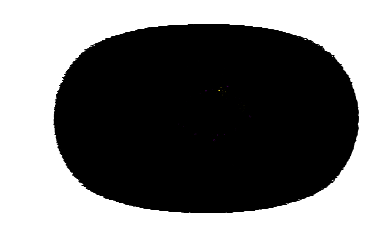

In [21]:
N = len(urls)
start_distribution = np.ones((1, N)) / N
pr_distribution = page_rank(ls, start_distribution)

size_const = 10 ** 4
G = networkx.DiGraph()
G.add_nodes_from(range(N))
G.add_edges_from(ls)
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * pr_distribution, 
                       node_color=pr_distribution)

Хмм

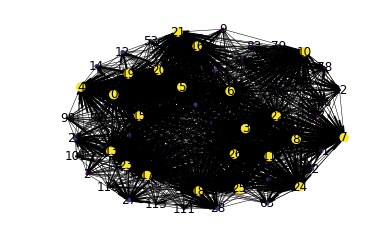

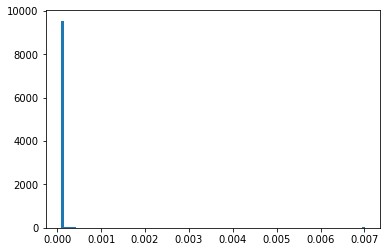

In [41]:
gv = set(sorted(range(N), key=lambda i: -pr_distribution[i])[:58])
gls = [l for l in ls if l[0] in gv and l[1] in gv]

size_const = 10 ** 4
G = networkx.DiGraph()
gvl = list(gv)
G.add_nodes_from(gvl)
G.add_edges_from(gls)
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * np.array([pr_distribution[i] for i in gvl]), 
                       node_color=np.array([pr_distribution[i] for i in gvl]))
plt.show()

plt.hist(pr_distribution, bins=100, label="ranks")
plt.show()

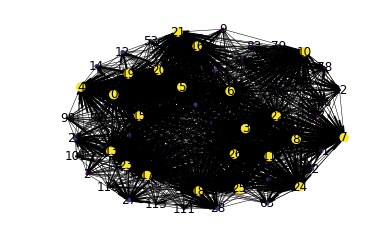

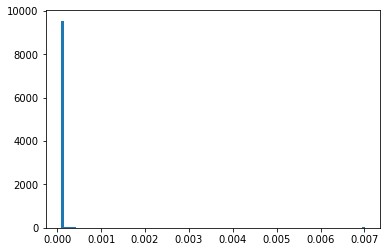

In [41]:
gv = set(sorted(range(N), key=lambda i: -pr_distribution[i])[:58])
gls = [l for l in ls if l[0] in gv and l[1] in gv]

size_const = 10 ** 4
G = networkx.DiGraph()
gvl = list(gv)
G.add_nodes_from(gvl)
G.add_edges_from(gls)
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * np.array([pr_distribution[i] for i in gvl]), 
                       node_color=np.array([pr_distribution[i] for i in gvl]))
plt.show()

plt.hist(pr_distribution, bins=100, label="ranks")
plt.show()

Здесь что-то почти полносвязное на вид. Почти у всех страниц веса очень близки к нулю. Но есть небольшой процент страниц с немного более далеким от 0 ранком.

http://www.maria-ra.ru/ -> 0.00701516610529
http://www.maria-ra.ru/o-nas/karta-seti/ -> 0.00701516610529
http://www.maria-ra.ru/o-nas/ -> 0.00701516610529
http://www.maria-ra.ru/aktsii/image/ -> 0.00701516610529
http://www.maria-ra.ru/novosti/ -> 0.00701516610529
http://www.maria-ra.ru/karera-v-seti/benefits/ -> 0.00701516610529
http://www.maria-ra.ru/partneram/ -> 0.00701516610529
http://www.maria-ra.ru/retsepty/ -> 0.00701516610529
http://www.maria-ra.ru/obratnaya-svyaz/ -> 0.00701516610529
http://www.maria-ra.ru/aktsii/ -> 0.00701516610529
http://www.maria-ra.ru -> 0.00701516610529
http://www.maria-ra.ru/o-nas/blagotvoritelnost/ -> 0.00701516610529
http://www.maria-ra.ru/aktsii/sotsialnye-proekty/ -> 0.00701516610529
http://www.maria-ra.ru/aktsii/trassa-zdorovya/ -> 0.00701516610529
http://www.maria-ra.ru/o-nas/adresa-magazinov/ -> 0.00701516610529


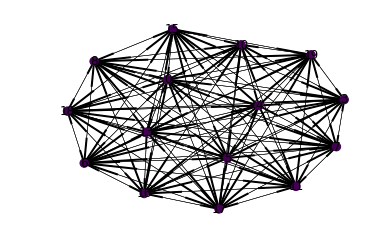

In [44]:
gv = set(sorted(range(N), key=lambda i: -pr_distribution[i])[:15])
gls = [l for l in ls if l[0] in gv and l[1] in gv]

print("\n".join([us[i] + " -> " + str(pr_distribution[i])  for i in gv]))

size_const = 10 ** 4
G = networkx.DiGraph()
gvl = list(gv)
G.add_nodes_from(gvl)
G.add_edges_from(gls)
plt.axis('off')
networkx.draw_networkx(G, width=0.5, node_size=size_const * np.array([pr_distribution[i] for i in gvl]), 
                       node_color=np.array([pr_distribution[i] for i in gvl]))
plt.show()

Все самые ранкистые страницы имеют одинаковый ранк. Напрашивается вывод, что эти ссылки всегда встречаются одновременно. Несложно понять, что они встречаются в шапке сайта.

Касательно последнего вопроса. Считать ничего не буду, так как это довольно долго. К тому же вывод можно сделать и так. Начальное приближение не играет особой роли, так как почти на всех страницах есть шапка. То есть ранк страниц шапки очень быстро сойдется с своему пределу. Ранки других вершин тоже быстро сойдутся. По сути этот граф очень близок к звезде, только вместо одной центральной вершины, тут сильносвязная компонента.

## Part 3 (50%)

Для выполнения этой части вам потребуется библиотека RankLib https://sourceforge.net/p/lemur/wiki/RankLib/

Скачайте датасет с конкурса «Интернет-математика 2009»
https://academy.yandex.ru/events/data_analysis/grant2009/

Разбейте его на три части train, test, valid размера 10% каждая.
Функции, реализующие это, возьмите с семинара.
Правда, привести файл к формату SVM-Rank (см. документацию по RankLib) придется самостоятельно.

Обучите на train методы MART и LambdaMART на 300 итераций, указав им метрику NDCG и передав так же valid.
Записывайте сюда команды аналогично тому, как это было сделано на семинаре.
Значения метрики в зависимости от номера итерации сохранились в log-файле.
Для считывания поможет приведенная ниже функция.

In [ ]:
def read_metric_dependence_from_file(file_name, num_lines, num_blocks=1):
    ''' Извлекает значения метрики в процессе обучения из log-файлов, 
    создаваемых библиотекой RankLib при обучении.
        file_name --- имя log-файла
        num_lines --- число строк, в которых записаны значения. 
                      Смысл --- количество выполненых итераций при обучении.
        num_blocks --- количество блоков значений. 
                       Смысл --- число k в случае k-fold CV
                       
        Возвращает лист из np.array в количестве num_blocks.
    Первый столбец каждого np.array --- номер итерации. Все следующие --- значения.
    '''
    
    with open(file_name) as f:
        text = f.readlines()
    
    values = []
    for block_id in range(num_blocks):
        index = text.index('Training starts...\n') + 4
        block_values = np.array(list(map(lambda x: list(map(float, x.split('|')[:-1])), 
                                         text[index:index + num_lines])))
        values.append(block_values)
        text = text[index:]
        
    return values

Постройте график значения метрики NDCG в зависимости от номера итерации на train и valid для ранее обученных моделей MART и LambdaMART.

In [ ]:
values = (read_metric_dependence_from_file('... log_LambdaMART', 300)[0],
          read_metric_dependence_from_file('... log_MART', 300)[0])

plt.figure(figsize=(20, 8))
plt.plot(<x>, <y>, lw=2, label=<...>)
<...>
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.title(<...>)
plt.legend(loc=2)
plt.grid()
plt.show()

Можно ли сказать, что какая-то модель работает лучше? Достигается ли точка переобучения?

<Ответ>

Постройте аналогичные графики для Random Forests и RankNet (по отдельности).
Какие выводы можно сделать?

In [ ]:
<...>

#### Сглаживание дискретных метрик

Одна из основных проблем в обучении ранжированию --- дискретность метрик.
Мы знаем, как решается эта проблема в LambdaRank и LambdaMART (см. вопрос выше).
Однако, в некоторых задачах нужно использовать саму метрику.
В связи с этим возникают задачи разработки сглаженных версий дискретных метрик.
Рассмотрим самый простой из них.

Пусть $X_{train}$ --- обучающая выборка. Разобьем ее на две части независимо $M$ раз: $X_{train} = X_1^m \sqcup X_2^m$, причем разбиение будем производить *по запросам*, то есть пары $(q, d_1)$ и $(q, d_2)$ попадают в одну из этих двух частей. Далее обучаем наш метод на $X_1^m$ и применяем к $X_{test}$ --- тестовая выборка. Так мы получим $M$ чисел $Z_1, ..., Z_M$, каждое из которых есть значение метрики. Их усреднение дает сглаженное значение метрики.

Почему такой способ является нечестным? Как нужно было бы действовать честно?

<Ответ>

Теперь вам предстоит построить график сглаженной метрики $NDCG_{10}$ для LambdaMART c 300 деревьями и $M=10$.
Алгоритм примерно следующий:

на каждой итерации
* перемешать $X_{train}$ по запросам. Для этого есть специальная команда, см. описание библиотеки.
* разбить $X_{train}$ на две части. Для этого есть функция с семинара.
* обучить LambdaMART на первой части на 300 деревьях. Валидационную выборку передавать не нужно.
* посчитать значение NDCG на $X_{test}$ по полученной модели в зависимости от количества деревьев.

В последнем пункте имеется ввиду следующее. 
Пусть модель представляется в виде $F(x) = \sum\limits_{t=1}^T \alpha_t f_t(x)$.
Нужно посчитать значение метрики по всем моделям $F(x) = \sum\limits_{t=1}^K \alpha_t f_t(x), K=1, ..., T$.

Для реализации вам потребуется самостоятельно создать файл с такой моделью на основе файла с обученной моделью, который представляет из себя список деревьев с некоторой дополнительной информацией.
Вам нужно в свой файл последовательно добавлять деревья по одному, а затем использовать команду для подсчета значения метрики на тестовой выборке по этой модели, см. описание библиотеки.

Выполнив эти операции, постройте график сглаженной метрики. Сравните с графиком исходной метрики.

Выполнять консольные команды можно в цикле:

In [ ]:
for i in range(5):
    ! echo {np.log(i + 1) ** 2} > file.txt
    with open('file.txt') as f:
        print(f.read())

Если код выше не работает, воспользуйтесь следующей функцией.

In [ ]:
import subprocess

def _run_cmd(cmd, print=False):
    """ Запуск консольной команды cmd """
    
    PIPE = subprocess.PIPE
    p = subprocess.Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE,
                         stderr=subprocess.STDOUT, close_fds=True)
    output = ''
    
    while True:
        s = p.stdout.readline().decode('utf-8')
        if not s: break
        output += str(s)
        if print:
            print(s)
    
    return output